# Test Notebook
Using this notebook to test the library functions as it is being built.

In [2]:
# --- Standards
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
# --- relative
#import sys
#sys.path.insert(0, '../instrSimTools/')
from filters import *
from waveforms import *
from circuit import *


# LEC Cooling Section
The cooling section in the LEC will have 3 electron bunches for every proton bunch. The electron bunches are seperated at 197 MHz and Gaussian with $\sigma$ = 5 cm. The proton bunches are seperated at 24.6 MHz and have a flattened Cosine-squared shape as a result of the 2nd harmonic (49.2 MHz) cavity.

In [8]:
# --- Constants
pRF1 = 24.6e6   # RF frequency [Hz]
pRF2 = 49.3e6   # 2nd Harmonic RF frequency [Hz]
eRF1 = 197.1e6  # electron bunch seperation RF frequency [Hz]
e_sigma = 0.05 / const.c  # electron rms bunch length [s]
num_bunches = 1

time_ary = np.linspace(-1*(num_bunches*0.5)/pRF1, num_bunches*0.5/pRF1, 1000)  # time array for 1 RF cycle
e_time_ary = np.linspace(-1*(num_bunches*0.5)/eRF1, num_bunches*0.5/eRF1, 1000)
abs( time_ary[1] - time_ary[0] )

4.069109760166522e-11

In [9]:
# --- Make Proton Signal
proton_sig_1 = cosine_square_pulse(time_ary, (1/pRF1))
proton_sig_2 = mod_cos_sq_pulse( time_ary, (1/pRF1), pRF2, 1.0, 0.25, 0.0)*0.5

# --- Make Electron Signal
electron_sig, e_sigma_confirm = gaussian_pulse( time_ary, sigma=e_sigma)

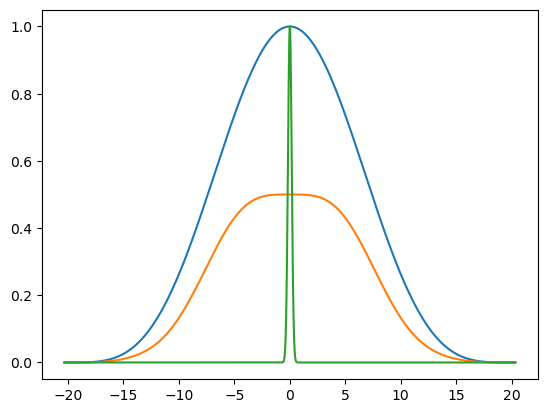

In [ ]:
plt.figure()
plt.plot(time_ary*1e9, proton_sig_1)
plt.plot(time_ary*1e9, proton_sig_2)
plt.plot(time_ary*1e9, electron_sig)
plt.show()

In [ ]:
# --- Make Electron Pulse Train
e_pulse_train = create_pulse_train(eRF1, electron_sig, time_ary, 3, pad_train=(2,2))
# abs( e_pulse_train[0][1] - e_pulse_train[0][0] )
shift_t = e_pulse_train[0].shape[0]//2
test_pulseTrain_time_ary = e_pulse_train[0] - e_pulse_train[0][shift_t-1]

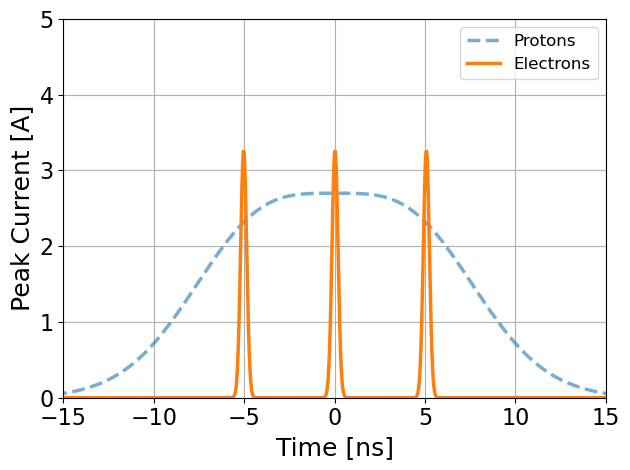

In [ ]:
plt.figure()
plt.plot( time_ary*1e9, 5.4*proton_sig_2, label='Protons', linewidth=2.5, linestyle='--', alpha=0.6)
plt.plot( test_pulseTrain_time_ary*1e9, 3.25*e_pulse_train[1], label='Electrons', linewidth=2.5)

# --- axis settings 
plt.xlabel('Time [ns]', fontsize=18)
plt.ylabel('Peak Current [A]', fontsize=18)
plt.legend(loc='upper right', fontsize=12)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.xlim( [-15, 15] )
plt.ylim( [0.0, 5.0] )
plt.tight_layout()

plt.show()

Good. Now make a pulse train of proton bunchese and electron macrobunches

In [ ]:
# --- Make Proton Pulse Train
p_pulse_train = create_pulse_train(pRF1, proton_sig_2, time_ary, 3)

In [ ]:
# --- Make electron macro-bunch train
e_macro_train = create_pulse_train(pRF1, e_pulse_train[1], test_pulseTrain_time_ary, 3)

In [ ]:
plt.figure()
plt.plot(p_pulse_train[0]*1e9, p_pulse_train[1])
plt.plot(e_macro_train[0]*1e9, e_macro_train[1])
plt.plot(e_macro_train[0]*1e9, square_wave(e_macro_train[0], pRF1))
plt.show()

#### BUG - Timing not right
Bug... the pulse is coming in much smaller than the period, so I need to add padding to make up the difference

In [ ]:
# --- Debug timing issue with pulse train
# --------------------------------------------------------------

Fs = 1 / (test_pulseTrain_time_ary[1] - test_pulseTrain_time_ary[0])
pulse_period = 1 / pRF1
print("electron_sig size: {}".format(electron_sig.size))

temp = e_pulse_train[1][test_pulseTrain_time_ary > -pulse_period / 2]
print("0.5 * Pulse period: |{}|".format(pulse_period/2))
temp_time_ary = test_pulseTrain_time_ary[test_pulseTrain_time_ary > -pulse_period / 2]
print("Upper - Cut --> temp size: {}".format(temp.size))

temp = temp[temp_time_ary < pulse_period / 2]
print("Lower - Cut --> temp size: {}".format(temp.size))

pulse_ary = np.copy( temp )
print("pulse ary size: {}".format(pulse_ary.size))

In [ ]:
temp_time_ary[-1]-temp_time_ary[0]

In [ ]:
# Check if pulse_time is smaller than pulse_period
if (test_pulseTrain_time_ary[-1] - test_pulseTrain_time_ary[0]) < pulse_period:
    # Calculate the number of samples to zero-pad
    num_zeros = int((pulse_period - (test_pulseTrain_time_ary[-1] - test_pulseTrain_time_ary[0])) * Fs)
    
    # Zero-pad the pulse
    temp_pulse = np.pad(e_pulse_train[1], num_zeros//2, mode='constant')
    
print("temp_pulse size: {}".format(temp_pulse.size))

In [ ]:
# --- create new timing array... 
new_time_ary_linspace = np.linspace( -0.5*pulse_period, 0.5*pulse_period, temp_pulse.size )
print("new_time_ary_linspace size: {}".format(new_time_ary_linspace.size))
new_time_ary_arange = np.arange( -0.5*pulse_period, 0.5*pulse_period, 1/Fs )
print("new_time_ary_arange size: {}".format(new_time_ary_arange.size))


In [ ]:
plt.figure()
plt.plot( test_pulseTrain_time_ary*1e9, e_pulse_train[1] )
plt.plot( new_time_ary_arange*1e9, temp_pulse )
plt.show()

Good... fixed
____
#### Back to testing

In [ ]:
# --- Re - Make electron macro-bunch train
e_macro_train = create_pulse_train(pRF1, e_pulse_train[1], test_pulseTrain_time_ary, 3)

In [ ]:
plt.figure()
plt.plot(p_pulse_train[0]*1e9, p_pulse_train[1])
plt.plot(e_macro_train[0]*1e9, e_macro_train[1])
plt.plot(e_macro_train[0]*1e9, square_wave(e_macro_train[0], pRF1))
plt.show()

Excellent! Now to make it look pretty with fancy plotting. <br><br>
Note: Pulse trains have a full period before and after. Consider making this optional. 

In [ ]:
# --- Make Proton Pulse Train
p_pulse_train = create_pulse_train(pRF1, proton_sig_2, time_ary, 5)
# --- Make electron macro-bunch train
e_macro_train = create_pulse_train(pRF1, e_pulse_train[1], test_pulseTrain_time_ary, 5)

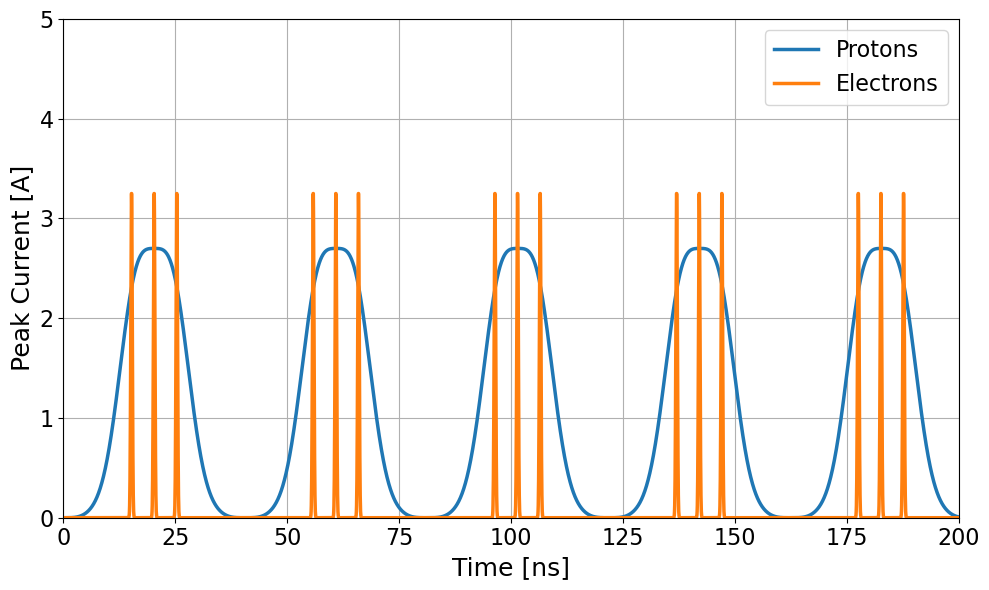

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(p_pulse_train[0] * 1e9, 5.4*p_pulse_train[1], label='Protons',linewidth=2.5)
plt.plot(e_macro_train[0] * 1e9, 3.25*e_macro_train[1], label='Electrons',linewidth=2.5)

plt.xlabel('Time [ns]', fontsize=18)
plt.ylabel('Peak Current [A]', fontsize=18)
plt.legend(loc='upper right', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.xlim( [0, 200] )
plt.ylim( [0.0, 5.0] )
plt.tight_layout()
plt.show()

In [ ]:
idx = np.argmax( p_pulse_train[1] )
peak_1 = p_pulse_train[0][idx]
peak_2 = p_pulse_train[0][idx+np.argmax( p_pulse_train[1][idx+5:] )]
# peak_2 = np.argmax( p_pulse_train[1][idx+5:] )
print(f"Peak 1: {peak_1*1e9:.2f} ns")
print(f"Peak 2: {peak_2*1e9:.2f} ns")

In [ ]:
# --- Make LEReC Electron Signal
lerec_sigma = 0.02 / const.c  # electron rms bunch length [s]
LEReC_time_ary = np.linspace(-1*(1*0.5)/(9.1e6), 1*0.5/(9.1e6), 1000)  # time array for 1 RF cycle
LEReC_sig, sigma_conf = gaussian_pulse( LEReC_time_ary, sigma=lerec_sigma)
# --- Make LEReC Electron Macro-bunch
LEReC_macro_bunch = create_pulse_train(704e6, LEReC_sig, LEReC_time_ary, 30, pad_train=(2,2))
# --- Make LEReC Pulse Train
LEReC_pulse_train = create_pulse_train((9.1e6), LEReC_macro_bunch[1], LEReC_macro_bunch[0], 5)

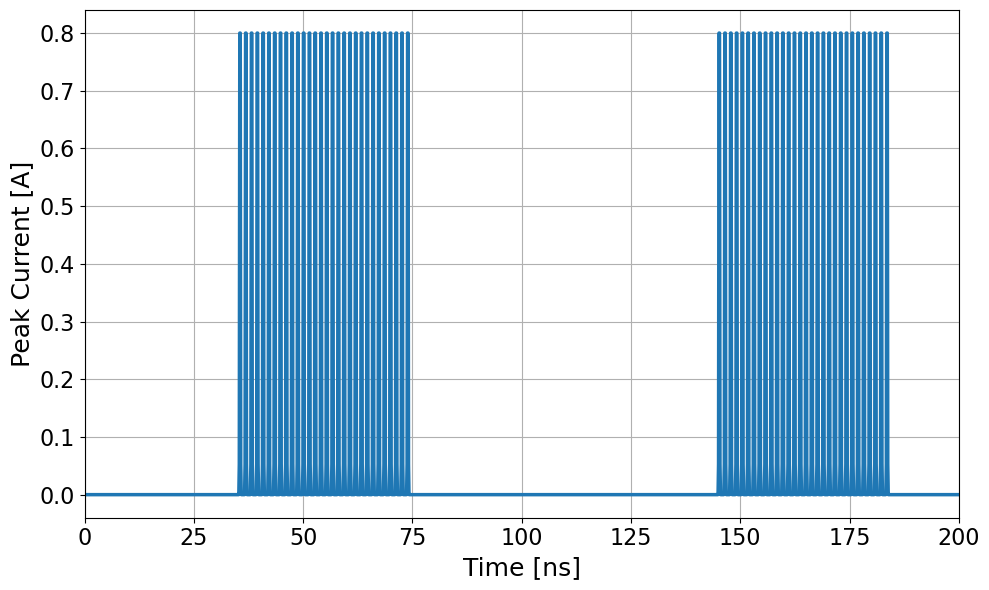

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(LEReC_pulse_train[0] * 1e9, 0.8*LEReC_pulse_train[1], label='Electrons',linewidth=2.5)

plt.xlabel('Time [ns]', fontsize=18)
plt.ylabel('Peak Current [A]', fontsize=18)
# plt.legend(loc='upper right', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.xlim( [0, 200] )
# plt.ylim( [0.0, 6.0] )
plt.tight_layout()
plt.show()

### Make Spectrum Plots

In [ ]:
num_bunches = 10
time_ary = np.linspace(-1*(num_bunches*0.5)/pRF1, num_bunches*0.5/pRF1, 20000)  # time array for 1 RF cycle
pFs = 1/(time_ary[1] - time_ary[0])

NameError: name 'np' is not defined

In [ ]:
proton_sig_2 = mod_cos_sq_pulse( time_ary, (1/pRF1), pRF2, 1.0, 0.25, 0.0)*0.5

# --- Proton Spectrum
PS2_freq, PS2_spec = get_spectrum( proton_sig_2, pFs )

In [ ]:
# --- Make Electron Signal
electron_sig, e_sigma_confirm = gaussian_pulse( time_ary, sigma=e_sigma)
# --- Make Electron Pulse Train
e_pulse_train = create_pulse_train(eRF1, electron_sig, time_ary, 3, pad_train=(2,2))
emb_Fs = 1/(e_pulse_train[0][1] - e_pulse_train[0][0])
# --- Electron Spectrum
e_freq, e_spec = get_spectrum( electron_sig, pFs )
emb_freq, emb_spec = get_spectrum( e_pulse_train[1], emb_Fs )

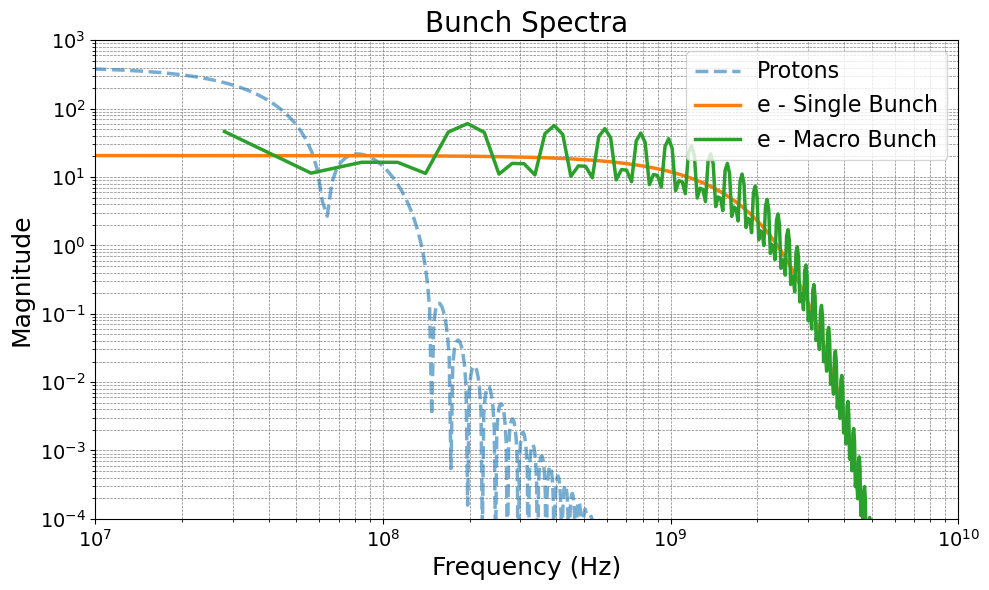

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(PS2_freq[PS2_freq>0], np.abs(PS2_spec[PS2_freq>0]), label='Protons', linewidth=2.5, linestyle='--', alpha=0.6)
ax.plot(e_freq[e_freq>0], np.abs(e_spec[e_freq>0]), label='e - Single Bunch',linewidth=2.5)
ax.plot(emb_freq[emb_freq>0], np.abs(emb_spec[emb_freq>0]), label='e - Macro Bunch',linewidth=2.5)
# --- 
ax.set_xlim(1e7, 1e10)
ax.set_ylim(1e-4, 1e3)  # set y-axis limits to log scale
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Frequency (Hz)', fontsize=18)
ax.set_ylabel('Magnitude', fontsize=18)
ax.grid(True, which='both', ls='--', lw=0.5, color='gray')
ax.legend(loc='upper right', fontsize=16)
# --- 
plt.title("Bunch Spectra", fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.show()

In [ ]:
# --- Make Proton Pulse Train
p_pulse_train = create_pulse_train(pRF1, proton_sig_2, time_ary, 5, pad_train=(2,2))
# --- Make electron macro-bunch train
e_macro_train = create_pulse_train(pRF1, e_pulse_train[1], test_pulseTrain_time_ary, 5, pad_train=(2,2))

In [ ]:
# --- Bunch Train Spectra
pt_FS = 1 / (p_pulse_train[0][1]-p_pulse_train[0][0])
et_FS = 1 / (e_macro_train[0][1]-e_macro_train[0][0])

pt_freq, pt_spec = get_spectrum( p_pulse_train[1], pt_FS )
et_freq, et_spec = get_spectrum( e_macro_train[1], et_FS )

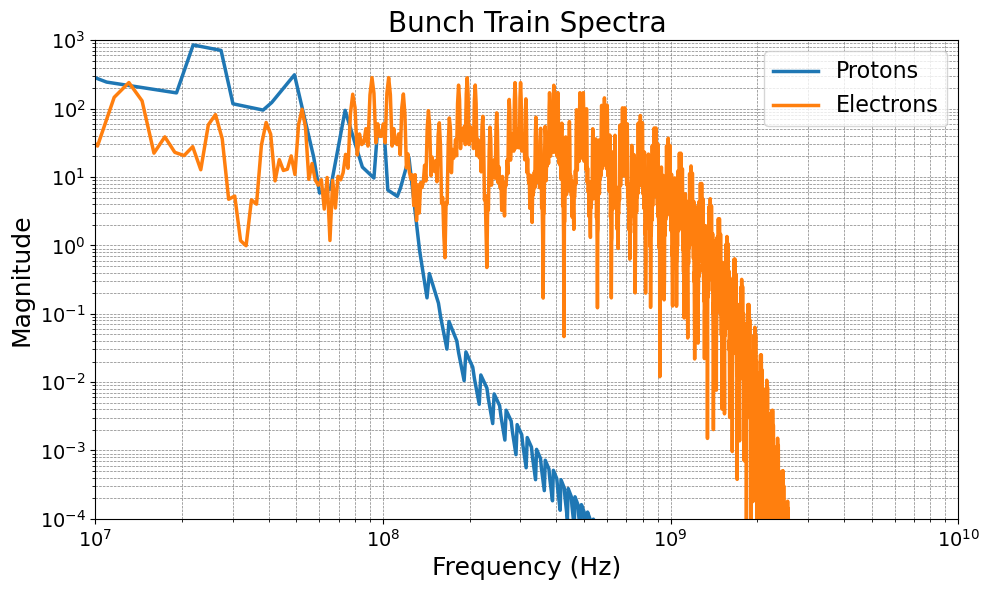

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(pt_freq[pt_spec>0], np.abs(pt_spec[pt_spec>0]), label='Protons',linewidth=2.5)
ax.plot(et_freq[et_freq>0], np.abs(et_spec[et_freq>0]), label='Electrons',linewidth=2.5)
# --- 
ax.set_xlim(1e7, 1e10)
ax.set_ylim(1e-4, 1e3)  # set y-axis limits to log scale
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Frequency (Hz)', fontsize=18)
ax.set_ylabel('Magnitude', fontsize=18)
ax.grid(True, which='both', ls='--', lw=0.5, color='gray')
ax.legend(loc='upper right', fontsize=16)
# --- 
plt.title("Bunch Train Spectra", fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.show()

# Wall Current Monitor Simulation
The goal is to create an RLC simulation of a wall current monitor

In [19]:
# --- RHIC WCM Circuit
# --- --- Analytical Model
wcm_ntwk = simple_wcm_circuit( Cb=65.17e-12, Cc=15e-12, Cp=0.5e-12*83, Ls=2e-9/83, Lby=189.79e-6, Rp=100/83 )

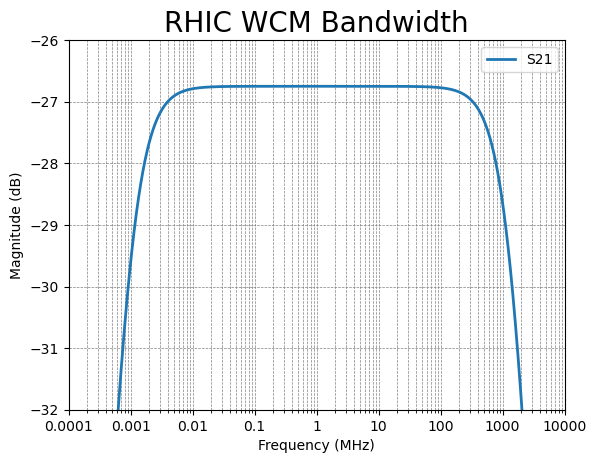

In [20]:
wcm_ntwk.plot_s_db(m=1, n=0, lw=2, logx=True )
plt.grid(True, which='both', ls='--', lw=0.5, color='gray')
plt.ylim([-32, -26])
plt.title("RHIC WCM Bandwidth", fontsize=20)
plt.show()

In [21]:
BW, Flow, Fhigh, pass_mag = measure_3db_bandwidth( wcm_ntwk )
print( "{} MHz".format(BW*1e-6) )
print( "{} Hz".format(Flow) )
print( "{} MHz".format(Fhigh*1e-6) )
print( "{} dB".format(pass_mag) )

1342.7639948200185 MHz
966.3178455932789 Hz
1342.764961137864 MHz
-26.74918505736073 dB


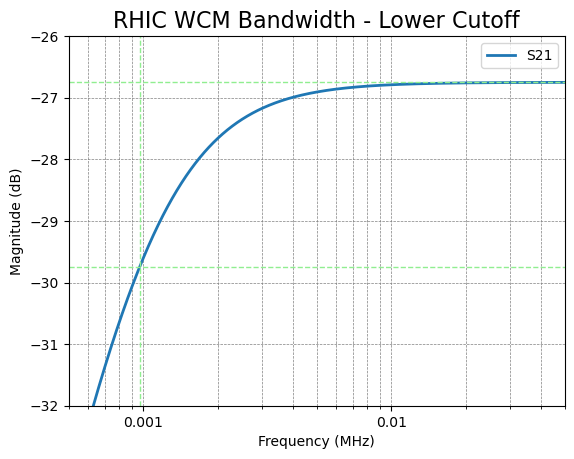

In [22]:
wcm_ntwk.plot_s_db(m=1, n=0, lw=2, logx=True )
plt.grid(True, which='both', ls='--', lw=0.5, color='gray')
# Add dashed horizontal line at the passband magnitude
plt.axhline(y=pass_mag, color='lightgreen', linestyle='--', linewidth=1)
# Add dashed horizontal line at the passband magnitude - 3dB
plt.axhline(y=pass_mag-3, color='lightgreen', linestyle='--', linewidth=1)
# Add dashed vertical line at 3dB mark
plt.axvline(x=Flow, color='lightgreen', linestyle='--', linewidth=1)
plt.ylim([-32, -26])
plt.xlim([0.0005e6, 0.05e6])
plt.title("RHIC WCM Bandwidth - Lower Cutoff", fontsize=16)
plt.show()

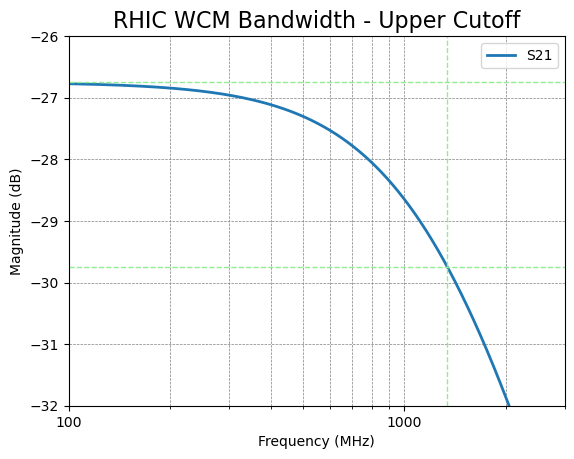

In [23]:
wcm_ntwk.plot_s_db(m=1, n=0, lw=2, logx=True )
plt.grid(True, which='both', ls='--', lw=0.5, color='gray')
# Add dashed horizontal line at the passband magnitude
plt.axhline(y=pass_mag, color='lightgreen', linestyle='--', linewidth=1)
# Add dashed horizontal line at the passband magnitude - 3dB
plt.axhline(y=pass_mag-3, color='lightgreen', linestyle='--', linewidth=1)
# Add dashed vertical line at 3dB mark
plt.axvline(x=Fhigh, color='lightgreen', linestyle='--', linewidth=1)
plt.ylim([-32, -26])
plt.xlim([100e6,3000e6])
plt.title("RHIC WCM Bandwidth - Upper Cutoff", fontsize=16)
plt.show()

## Test Vector Fitting
Export the RLC model using Vector Fitting to test out how to do it.

C:\Users\mpaniccia\AppData\Local\Temp\1\ipykernel_3796\177140861.py:2: UserWarning: The fitted network is passive, but the vector fit is not passive. Consider running `passivity_enforce()` to enforce passivity before using this model.
  vf.vector_fit( )


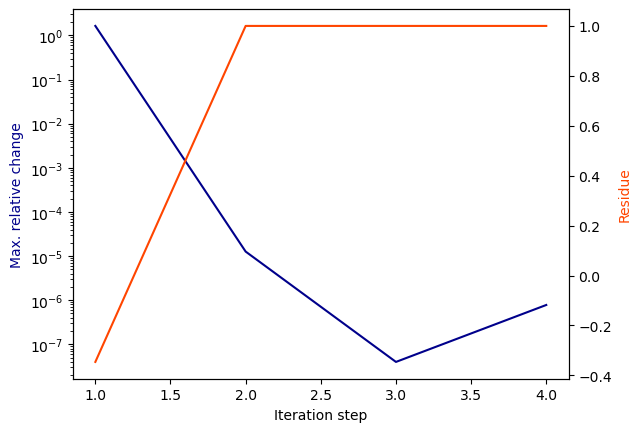

In [24]:
vf = rf.VectorFitting( wcm_ntwk )
vf.vector_fit( )
vf.plot_convergence()
plt.show()

In [25]:
vf.passivity_enforce()
vf.get_rms_error()

C:\Users\mpaniccia\AppData\Local\Temp\1\ipykernel_3796\1052370547.py:1: UserWarning: Passivity enforcement: The dc point in the model is not passive. Cannot preserve the dc point during passivity enforcement. 
  vf.passivity_enforce()
C:\Users\mpaniccia\AppData\Local\Temp\1\ipykernel_3796\1052370547.py:1: UserWarning: Passivity enforcement: The passivity violations of this model are unbounded. Passivity enforcement might still work, but consider re-fitting with a lower number of poles and/or without the constants (`fit_constant=False`) if the results are not satisfactory.
  vf.passivity_enforce()
C:\Users\mpaniccia\AppData\Local\Temp\1\ipykernel_3796\1052370547.py:1: RuntimeWarning: Passivity enforcement was not successful.
Model is still non-passive in these frequency bands: [[2.00191006e+18            inf]].
Try running this routine again with a larger number of samples (parameter `n_samples`). This run was using n_samples = 200. 
  vf.passivity_enforce()


2397.357858387441

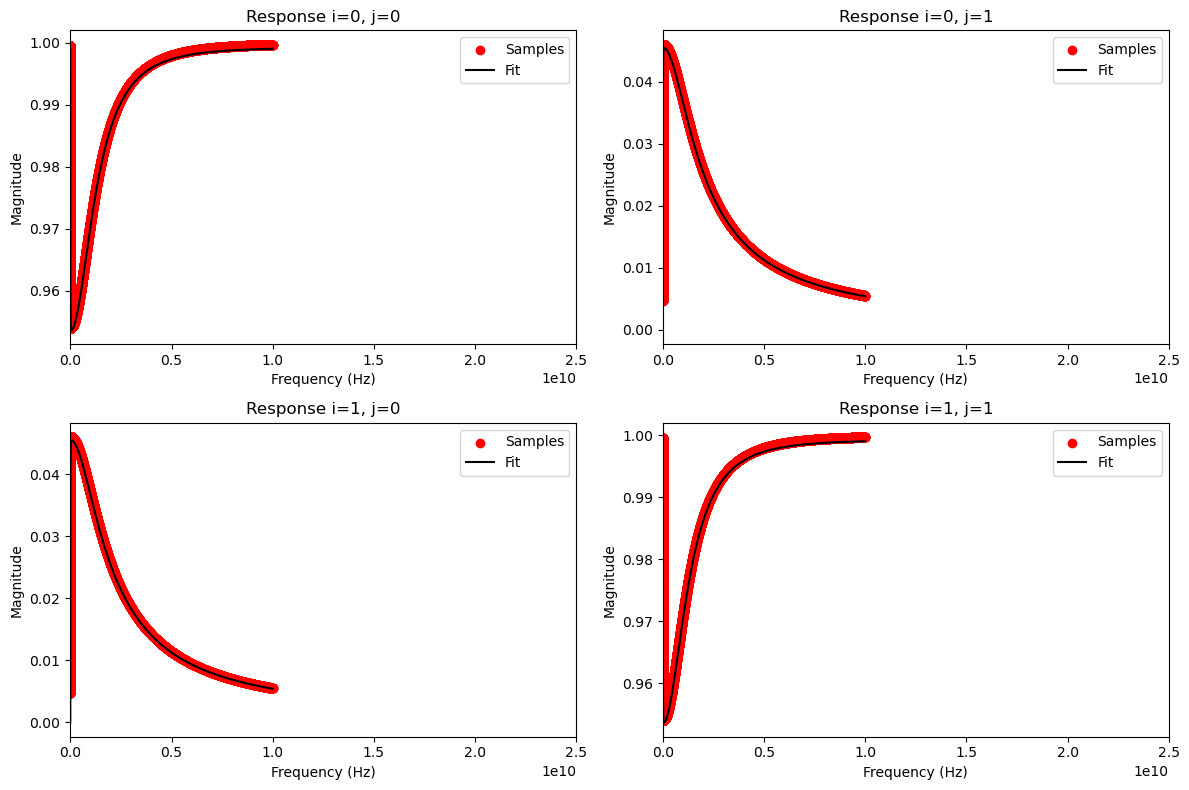

In [26]:
freqs1 = np.linspace(0, 10e9, 1001)
fig, ax = plt.subplots(2, 2)
fig.set_size_inches(12, 8)
vf.plot_s_mag(0, 0, freqs1, ax=ax[0][0]) # plot s11
ax[0][0].set_xlim([0.0, 0.25e11])
vf.plot_s_mag(1, 0, freqs1, ax=ax[1][0]) # plot s21
ax[1][0].set_xlim([0.0, 0.25e11])
vf.plot_s_mag(0, 1, freqs1, ax=ax[0][1]) # plot s12
ax[0][1].set_xlim([0.0, 0.25e11])
vf.plot_s_mag(1, 1, freqs1, ax=ax[1][1]) # plot s22
ax[1][1].set_xlim([0.0, 0.25e11])
fig.tight_layout()
plt.show()

In [27]:
#vf.write_spice_subcircuit_s( 'E:\\Qucs_Projects\\Tests\\WCM_Circuit.cir' )
vf.write_spice_subcircuit_s( 'E:\\SPICE_Projects\\spicelib\\testfiles\\WCM_Circuit.cir' )

FileNotFoundError: [Errno 2] No such file or directory: 'E:\\SPICE_Projects\\spicelib\\testfiles\\WCM_Circuit.cir'

In [ ]:
spice_time = time_ary-time_ary[0]
export_to_spice_pwl( spice_time, proton_sig_2, 'E:\\SPICE_Projects\\spicelib\\WCM_Test\\proton_sig_pwl.txt' )

__Direct Multiply with S21__

In [ ]:
wcm_ntw = wcm_ntwk.extrapolate_to_dc()
wcm_s21 = wcm_ntw.s[:,1,0]
Sig_s = fft(proton_sig_2)
Sig_s = 2*Sig_s[:proton_sig_2.size//2]

Tp = time_ary[1] - time_ary[0]
Fspec = fftfreq(proton_sig_2.size, Tp)
Fspec = Fspec[:proton_sig_2.size//2]
Fspec_step = Fspec[1] - Fspec[0]

In [ ]:
# --- Interpolation and Linearization
Fx = interp1d(Fspec, Sig_s)
Filt = interp1d(wcm_ntw.f, wcm_s21)
Freqx = np.arange(0.0, wcm_ntw.f[-1], Fspec_step)
NSig_s = Fx(Freqx)
Nlc_s21 = Filt(Freqx)

c:\ProgramData\anaconda3\Lib\site-packages\matplotlib\cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\ProgramData\anaconda3\Lib\site-packages\matplotlib\cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


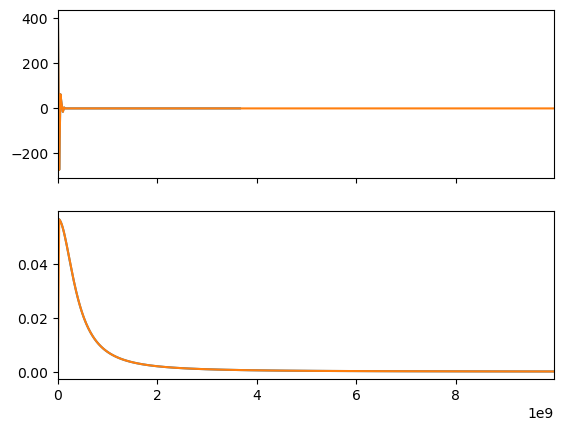

In [ ]:
# ---- Check Interpolation
fig, ax = plt.subplots(nrows=2, sharex=True)
ax[0].plot(Fspec[:150], np.real(Sig_s[:150]))
ax[0].plot(Freqx, np.real(NSig_s) )
ax[0].set_xlim([0.0, Freqx[-1]] )

ax[1].plot(wcm_ntw.f, wcm_s21)
ax[1].plot(Freqx, Nlc_s21)
ax[1].set_xlim([0.0, Freqx[-1]] )
plt.show()

In [ ]:
from scipy.fftpack import ifft


In [ ]:
Filt_Sig = NSig_s * Nlc_s21 
sig_filt = ifft( Filt_Sig )
#sig_filt *= (sig_filt.size/(Tp*2))
sig_ifft = ifft( Sig_s[:150] ) 

In [ ]:
time_ary.size

1000

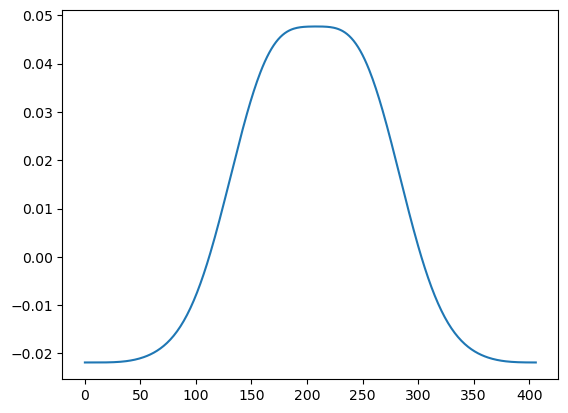

In [ ]:
plt.figure()
plt.plot(sig_filt)
#plt.plot(sig_ifft)
plt.show()

## SPICE Lab - WCM Tests
Using the spicelab library, see if I can run through simulations of the RHIC WCM over the new HSR waveforms

In [5]:
from spicelib import SimRunner, AscEditor, RawRead
from spicelib.log.ltsteps import LTSpiceLogReader
from spicelib.simulators.ltspice_simulator import LTspice
from pathlib import Path

In [6]:
# --- Get LTSpice File Path
path = input('file path: ')
name = input('file name (include extension): ')
asc_path = path + '\\' + name
# --- Create Output Folder
sim_output_path = path + '\\batch_output'
folder = Path(sim_output_path)
folder.mkdir(parents=True, exist_ok=True)

In [30]:
# select spice model
runner = SimRunner(simulator=LTspice, output_folder=sim_output_path)
wcm_asc = AscEditor(asc_path)

# set default arguments
wcm_asc.set_parameters(llf=189.79e-6, cbr=65.17e-12, ccc=15.7e-12, Ls=(2e-9/83), Cp=(0.5e-12)*83, rwcm=(100/83), rload=49.9 )
wcm_asc.add_instructions(
    "; Simulation settings",
    ";.param run = 0"
)
wcm_asc.set_parameter('run', 0)

In [8]:
# --- Make signals to test -- HSR Signals
num_bunches = 2
time_ary = np.linspace(-1*(num_bunches*0.5)/HSR_RF_24M, num_bunches*0.5/HSR_RF_24M, 3000)  # time array for 1 RF cycle

# --- Make HSR Signals
HSR_SIGS = {
    'INJ': cosine_square_pulse( time_ary, (1/HSR_RF_24M) ),
    'COOL': mod_cos_sq_pulse( time_ary, (1/HSR_RF_24M), HSR_RF_49M, 1.0, 0.25, 0.0 ),
    'RAMP': mod_cos_sq_pulse( time_ary, (1/HSR_RF_24M), HSR_RF_197M, 1.0, 0.33, 0.0 ),
    'STORE1': cosine_square_pulse( time_ary, (1/HSR_RF_197M) ),
    'STORE2': cosine_square_pulse( time_ary, (1/HSR_RF_591M) ),
}

In [9]:
spice_time = time_ary-time_ary[0]
Waveforms = {}
waveform_path = 'E:\\SPICE_Projects\\spicelib\\WCM_Test\\'

for waveform in HSR_SIGS.keys():              # --- Cycle through list of waveforms
    Waveforms[waveform] = waveform_path + 'Waveform_{}.txt'.format(waveform)
    export_to_spice_pwl( spice_time, HSR_SIGS[waveform], Waveforms[waveform] )

In [31]:
wcm_asc.remove_Xinstruction(r"\.TRAN.*")
wcm_asc.add_instructions(".TRAN 1p 100n 0 10p")

Instructions matching "\.TRAN.*" not found


In [32]:
alt_solver = True
for waveform in Waveforms.keys():              # --- Cycle through list of waveforms
    wcm_asc['I1']['Value'] = "PWL SCOPEDATA="+ Waveforms[waveform]  # --- Set V1 model to selected waveform
    print("simulating response to:", waveform)

    # small example on how to use options, here how to force the solver
    opts = []
    if alt_solver:
        opts.append('-alt')
    else:
        opts.append('-norm')

    runner.run(wcm_asc, switches=opts, exe_log=True)  # run, and log console output fo file

simulating response to: INJ
simulating response to: COOL
simulating response to: RAMP
simulating response to: STORE1
simulating response to: STORE2


In [34]:
data_test = {}
for raw, log in runner:
    print("Raw file: %s, Log file: %s" % (raw, log))
    # do something with the data
    raw_data = RawRead(raw)
    x = raw_data.get_wave('time')
    y1 = raw_data.get_wave('V(wcm_in)')
    y2 = raw_data.get_wave('V(wcm_out)')
    data_test[str(raw)[-1]] = (x, y1, y2)
    
    log_data = LTSpiceLogReader(log)
    # ...

# Sim Statistics
print('Successful/Total Simulations: ' + str(runner.okSim) + '/' + str(runner.runno))

Raw file: E:\SPICE_Projects\spicelib\WCM_Test\batch_output\wcm_testckt_1.raw, Log file: E:\SPICE_Projects\spicelib\WCM_Test\batch_output\wcm_testckt_1.log
Raw file: E:\SPICE_Projects\spicelib\WCM_Test\batch_output\wcm_testckt_2.raw, Log file: E:\SPICE_Projects\spicelib\WCM_Test\batch_output\wcm_testckt_2.log
Raw file: E:\SPICE_Projects\spicelib\WCM_Test\batch_output\wcm_testckt_3.raw, Log file: E:\SPICE_Projects\spicelib\WCM_Test\batch_output\wcm_testckt_3.log
Raw file: E:\SPICE_Projects\spicelib\WCM_Test\batch_output\wcm_testckt_4.raw, Log file: E:\SPICE_Projects\spicelib\WCM_Test\batch_output\wcm_testckt_4.log
Raw file: E:\SPICE_Projects\spicelib\WCM_Test\batch_output\wcm_testckt_5.raw, Log file: E:\SPICE_Projects\spicelib\WCM_Test\batch_output\wcm_testckt_5.log
Successful/Total Simulations: 5/5


In [12]:
x = raw_data.get_wave('time')
y =raw_data.get_wave('V(wcm_out)')  

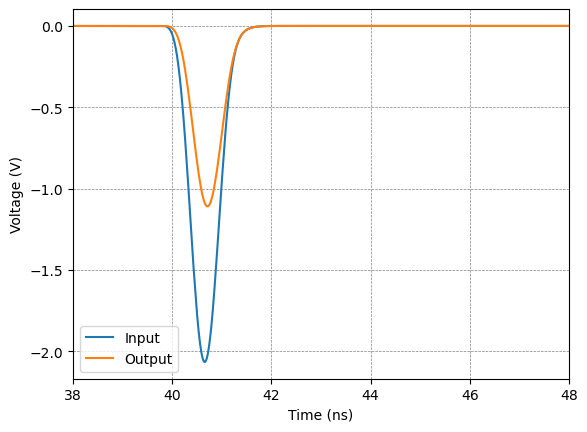

In [40]:
plt.Figure()
plt.plot(x*1e9,y1,x*1e9,y2)
plt.xlim([38, 48])
plt.xlabel('Time (ns)')
plt.ylabel('Voltage (V)')
plt.legend(['Input', 'Output'])
plt.grid(True, which='both', ls='--', lw=0.5, color='gray')
plt.show()

In [29]:
enter = input("Press enter to delete created files")
if enter == '':
    runner.cleanup_files()

# HSR Profiles

In [2]:
# --- Make signals to test -- HSR Signals
num_bunches = 2
time_ary = np.linspace(-1*(num_bunches*0.5)/HSR_RF_24M, num_bunches*0.5/HSR_RF_24M, 3000)  # time array for 1 RF cycle

In [3]:
# --- Make HSR Signals
HSR_SIGS = {
    'PP_INJ'    : cosine_square_pulse( time_ary, HSR_PP_BUNCH_LENGTH_23GeV, pw_type="rms" ),
    'Au_INJ'    : cosine_square_pulse( time_ary, HSR_AU_BUNCH_LENGTH_10GeV, pw_type="rms" ),
    'PP_COOL'   : mod_cos_sq_pulse( time_ary, (0.6/HSR_RF_24M), HSR_RF_24M, HSR_RF_49M, pulsAmp=1.0, modAmp=1.0, phi=0.0 ),
    'PP_RAMP'   : mod_cos_sq_pulse( time_ary, (0.6/HSR_RF_24M), HSR_RF_24M, HSR_RF_197M, pulsAmp=1.0, modAmp=0.75, phi=0.0 ),
    'PP_41GEV'  : cosine_square_pulse( time_ary, HSR_PP_BUNCH_LENGTH_41GeV, pw_type="rms" ),
    'PP_100GEV' : cosine_square_pulse( time_ary, HSR_PP_BUNCH_LENGTH_100GeV, pw_type="rms" ),
    'PP_275GEV' : cosine_square_pulse( time_ary, HSR_PP_BUNCH_LENGTH_275GeV, pw_type="rms" ),
    'AU_41GEV'  : cosine_square_pulse( time_ary, HSR_AU_BUNCH_LENGTH_41GeV, pw_type="rms" ),
    'AU_110GEV' : cosine_square_pulse( time_ary, HSR_AU_BUNCH_LENGTH_110GeV, pw_type="rms" ),
}

In [4]:
Fs = 1/(time_ary[1] - time_ary[0])

# --- Make HSR Spectra
HSR_SPECS = {
    'PP_INJ'    : get_spectrum( HSR_SIGS['PP_INJ'],     Fs )[1],
    'Au_INJ'    : get_spectrum( HSR_SIGS['Au_INJ'],     Fs )[1],
    'PP_COOL'   : get_spectrum( HSR_SIGS['PP_COOL'],    Fs )[1],
    'PP_RAMP'   : get_spectrum( HSR_SIGS['PP_RAMP'],    Fs )[1],
    'PP_41GEV'  : get_spectrum( HSR_SIGS['PP_41GEV'],   Fs )[1],
    'PP_100GEV' : get_spectrum( HSR_SIGS['PP_100GEV'],  Fs )[1],
    'PP_275GEV' : get_spectrum( HSR_SIGS['PP_275GEV'],  Fs )[1],
    'AU_41GEV'  : get_spectrum( HSR_SIGS['AU_41GEV'],   Fs )[1],
    'AU_110GEV' : get_spectrum( HSR_SIGS['AU_110GEV'],  Fs )[1],
}
freq_ary, __ = get_spectrum( HSR_SIGS['PP_INJ'], Fs )

### Injection

In [45]:
injection_sig = { 'PP_INJ':HSR_SIGS['PP_INJ'], 'Au_INJ':HSR_SIGS['Au_INJ'] }
injection_spec = { 'PP_INJ':HSR_SPECS['PP_INJ'], 'Au_INJ':HSR_SPECS['Au_INJ'] }

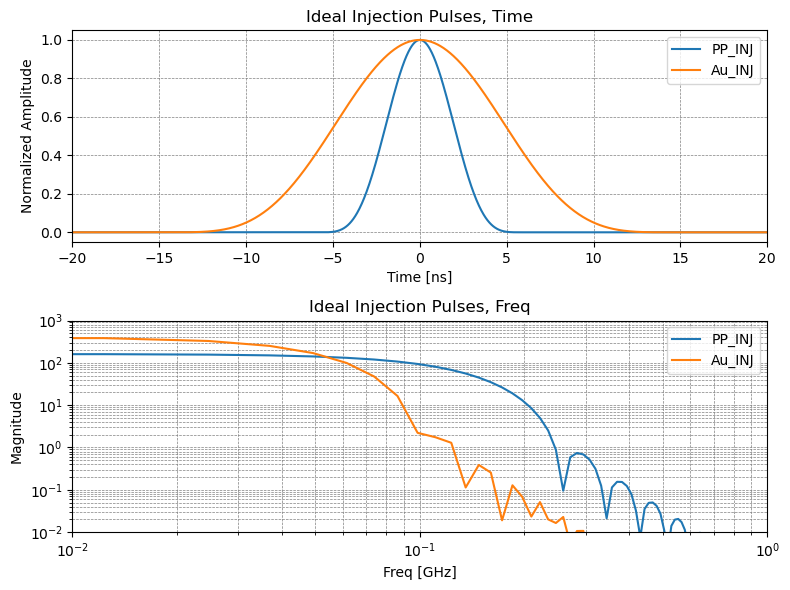

In [82]:
plot_gaus_pulses( time_ary, injection_sig, freq_ary, injection_spec,
                 ax1_xlim=[-20, 20], title="Ideal Injection Pulses",
                 ax2_xlim=[0.01, 1], ax2_ylim=[1e-2, 1000], loglog=True,
                 )

### Injection Cooling

C:\Users\mpaniccia\AppData\Local\Temp\5\ipykernel_32600\2362264454.py:90: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax1.legend()
C:\Users\mpaniccia\AppData\Local\Temp\5\ipykernel_32600\2362264454.py:101: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax2.legend()


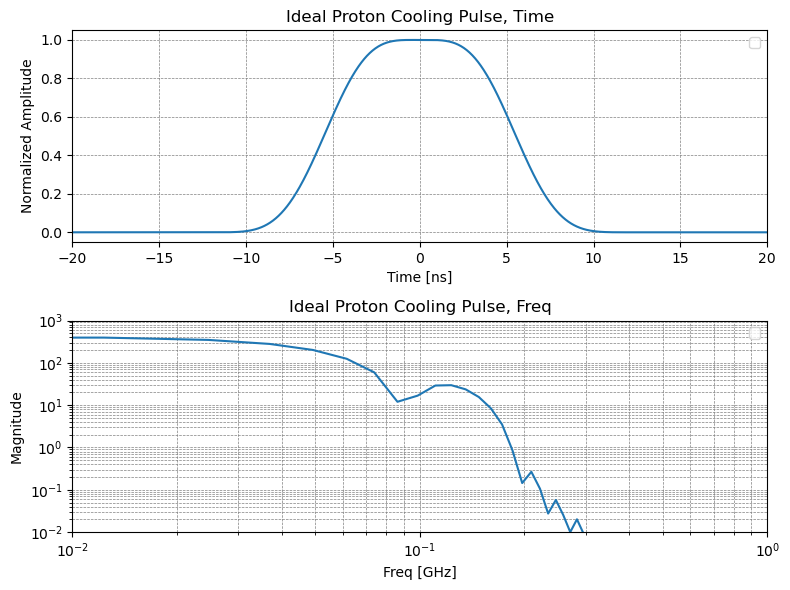

In [83]:
plot_gaus_pulses( time_ary, HSR_SIGS['PP_COOL'], freq_ary, HSR_SPECS['PP_COOL'],
                 ax1_xlim=[-20, 20], title="Ideal Proton Cooling Pulse",
                 ax2_xlim=[0.01, 1], ax2_ylim=[1e-2, 1000], loglog=True,
                 )

### Acceleration Ramp
- 197 Modulation 
- Splitting

C:\Users\mpaniccia\AppData\Local\Temp\5\ipykernel_32600\2362264454.py:90: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax1.legend()
C:\Users\mpaniccia\AppData\Local\Temp\5\ipykernel_32600\2362264454.py:101: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax2.legend()


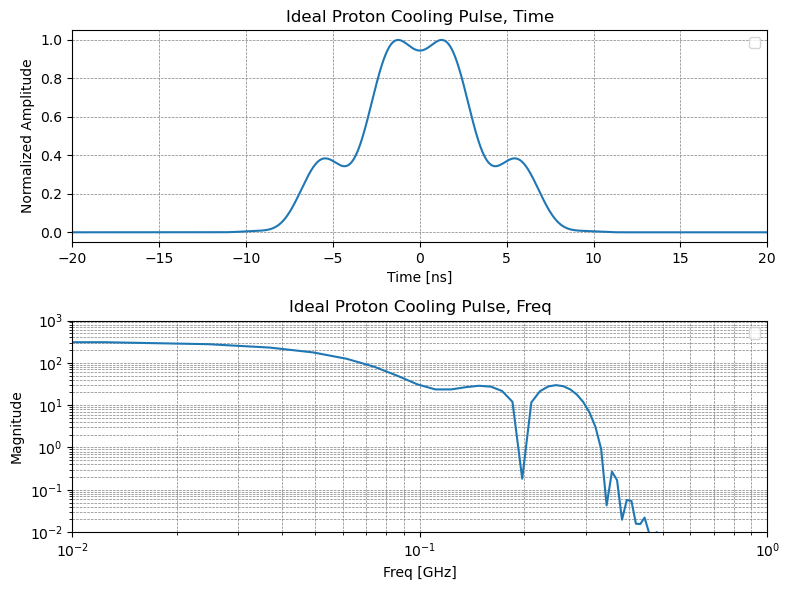

In [ ]:
plot_gaus_pulses( time_ary, HSR_SIGS['PP_RAMP'], freq_ary, HSR_SPECS['PP_RAMP'],
                 ax1_xlim=[-20, 20], title="Ramp Stability Pulse",
                 ax2_xlim=[0.01, 1], ax2_ylim=[1e-2, 1000], loglog=True,
                 )

Splitting

In [55]:
# --- Create waveforms representing the cavities performance during the splitting process
turns = 35000
cav1 = create_transition_array( turns, (1.0, 0.0), (10000), (5000) )
cav2 = create_transition_array( turns, (0.0, 1.0, 0.0), (5000, 25000), (5000) )
cav3 = create_transition_array( turns, (0.0, 1.0), (20000), (5000) )

In [56]:
# --- Build Cavities 
cap_sin = (np.cos(HSR_RF_24M*2*np.pi*time_ary)-1.0)**2
bs1_sin = (np.cos(HSR_RF_49M*2*np.pi*time_ary)-1.0)**2
bs2_sin = (np.cos(HSR_RF_98M*2*np.pi*time_ary)-1.0)**2
str1_sin = (np.cos(HSR_RF_49M*2*np.pi*time_ary+np.pi)-1.0)**2
str2_sin = (np.cos(HSR_RF_98M*2*np.pi*time_ary+np.pi)-1.0)**2

In [59]:
# --- --- split1 strength 
splt1_r = np.ones(turns)
splt1_r[300:325] = -1.0/(1250)+13
splt1_r[325:] = 0.0
# --- --- split2 strength 
splt2_r = np.ones(turns)
splt2_r[600:625] = -1.0/(1250)+25
splt2_r[625:] = 0.0

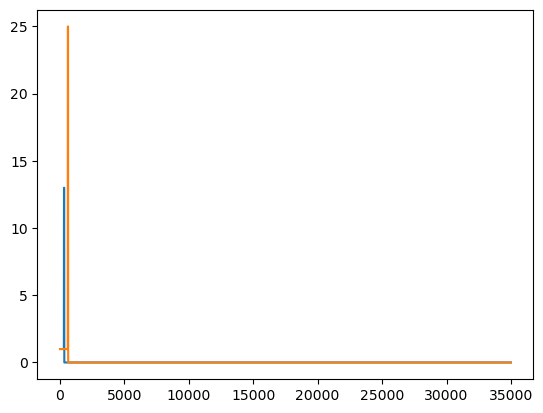

In [60]:
plt.figure()
plt.plot(splt1_r)
plt.plot(splt2_r)
plt.show()

In [62]:
sig_test = []
llast = []
last = np.trapz(HSR_SIGS['PP_INJ'])
for m1, m2, m3, s1, s2 in zip(cav1, cav2, cav3, splt1_r, splt2_r):
    # --- Add cavities together
    temp1 = m1*cap_sin
    temp1 += m2*bs1_sin
    temp1 += m3*bs2_sin
    # --- Add split together
    temp1 += -1*m2*( str1_sin+ np.sqrt(m1**2+m2**2) )
    temp1 += -1*m3*( str2_sin+ np.sqrt(m2**2+m3**2) )
    # --- Correct values
    temp1 -= temp1.min()
    temp1 /= temp1.max()
    temp1 *= last/np.trapz(temp1)
    sig_test.append( temp1 ) 
    last = np.trapz(temp1)
    llast.append(last)
sig_test = np.array(sig_test)

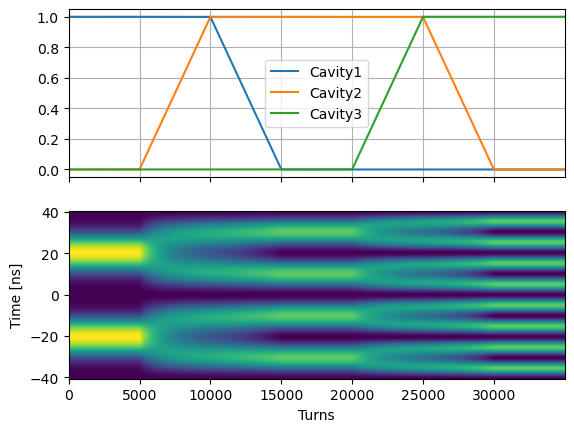

In [65]:
turn_ary = np.arange(turns)
fig, ax = plt.subplots(nrows=2, sharex=True)
ax[0].plot( turn_ary, cav1, turn_ary, cav2, turn_ary, cav3,)# turns, splt1_r, turns, splt2_r )
ax[0].grid()
ax[1].set_ylabel("Cavity Intensity [a.u.]")
ax[0].legend(["Cavity1","Cavity2","Cavity3",])
ax[1].pcolormesh( turn_ary, time_ary*1e9, sig_test.T, shading='nearest' )
ax[1].set_ylabel("Time [ns]")
ax[1].set_xlabel("Turns")
plt.show()

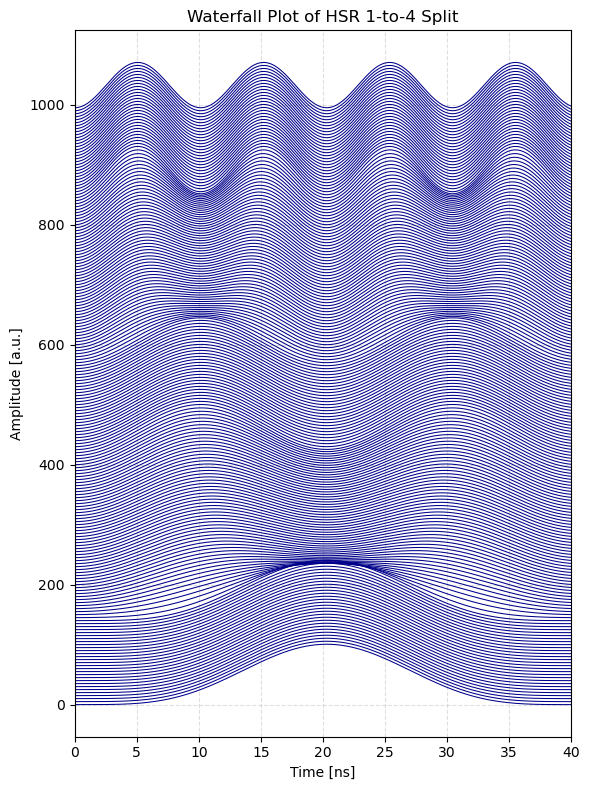

In [94]:
waterfall_plot(sig_test*700, time_ary*1e9, num_waveforms_to_plot=200,
               xlabel="Time [ns]", ylabel="Amplitude [a.u.]", title="Waterfall Plot of HSR 1-to-4 Split",
               xlim=[0.0, 40.0], figsize=(6, 8),
               )

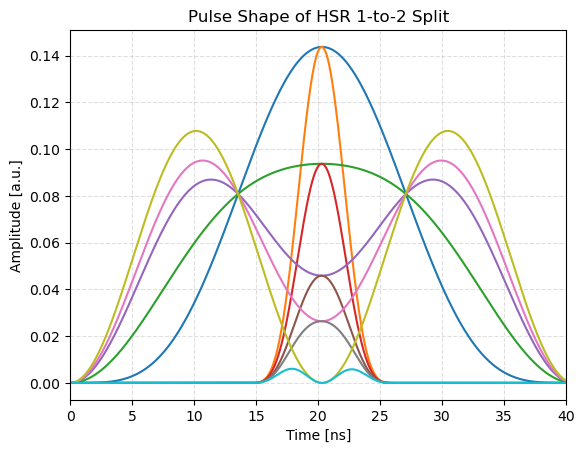

In [181]:
plt.figure()
for sig in sig_test[3000:18000:3000]:
    plt.plot(time_ary*1e9, sig)
    plt.plot(time_ary*1e9, sig*test)
#plt.plot(time_ary*1e9, test)
plt.xlabel("Time [ns]")
plt.xlim([0.0, 40.0])
plt.ylabel("Amplitude [a.u.]")
plt.title("Pulse Shape of HSR 1-to-2 Split")
plt.grid(True, linestyle='--', alpha=0.4)
plt.show()

## New Splitting Method
Goal will be to have N pulses added together and have their phases change based on the split. N respresent the final number of pulses.

In [ ]:
test_time = np.linspace(-2/(2*np.pi*HSR_RF_24M), 2/(2*np.pi*HSR_RF_24M), 10000)
phase_shift = 360.0
tst_p1 = cosine_square_pulse( test_time, HSR_PP_BUNCH_LENGTH_23GeV, pw_type="rms", phi=0.0 )*(1-phase_shift/180)
tst_p2 = cosine_square_pulse( test_time, HSR_PP_BUNCH_LENGTH_23GeV/1.5, pw_type="rms", phi=phase_shift )
tst_p3 = cosine_square_pulse( test_time, HSR_PP_BUNCH_LENGTH_23GeV/1.5, pw_type="rms", phi=-1*phase_shift )

In [337]:
# Need to determine the total phase shift to get to the new frequency. 
# For HSR, we are going from 24.6 MHz to 49.2 MHz to 98.5 MHz
d_phi = 1/(2*np.pi*HSR_RF_24M*360)
print(d_phi)
# Let's double check our phase shift
p1_peak_time = test_time[np.argmax(tst_p1)]
p2_peak_time = test_time[np.argmax(tst_p2)]
print( "Phase shift = {}\nExpected time shift = {}".format(phase_shift, d_phi*phase_shift))
print( "Actual time shift = {}".format(p1_peak_time - p2_peak_time) )
print( "Error = {}".format( p1_peak_time - p2_peak_time - d_phi*phase_shift) )

1.7948648755329015e-11
Phase shift = 0.0
Expected time shift = 0.0
Actual time shift = -1.292173467188331e-08
Error = -1.292173467188331e-08


In [338]:
split_phase_end1 = 1/(2*np.pi*HSR_RF_49M)/d_phi
print(split_phase_end1)

180.0


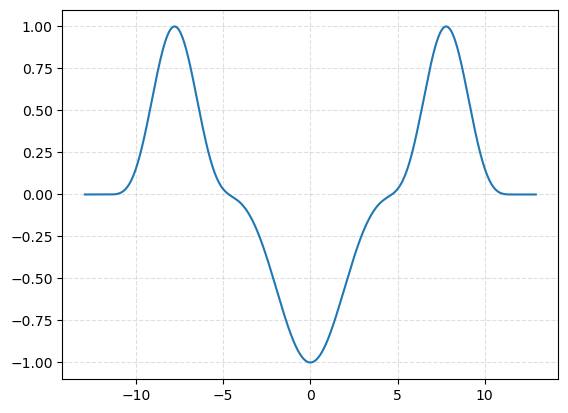

In [355]:
plt.figure()
plt.plot(test_time*1e9, tst_p1+tst_p2+tst_p3)
plt.grid(True, linestyle='--', alpha=0.4)
plt.show()

Works! Let's turn this into a function now...

In [11]:
def split_pulse_1_to_4( 
        rf:List[float],      # -- Expecting three RF frequencies, can be initial RF freq only
        bunch_length:List[float],   # -- Expecting bunch lengths in seconds, can be single value for initial
        split_steps:int=1000,
        bunch_shape:str="cos", 
        pw_type:str="rms", 
        dt:float=1e-12,
        ):
    # --- Constants
    num_bunches = 4
    num_splits = 2

    # --- Create Time array
    if isinstance(rf, (list, tuple, np.ndarray)): 
        base_rf = min(rf)
        rf_group = rf
    else:  
        base_rf = rf
        rf_group = [base_rf, base_rf*2, base_rf*2]
    
    time_resolution = int( (2/(np.pi*base_rf)) // dt )
    time_resolution = max(time_resolution, 1000)

    test_time = np.linspace(-3/(2*np.pi*base_rf), 3/(2*np.pi*base_rf), time_resolution)

    # --- Phase steps
    dphi = 90/split_steps

    # --- Bunch lengths
    if isinstance(bunch_length, (list, tuple, np.ndarray)):
        init_bunch_length = bunch_length[0]
        split1_bl = bunch_length[1]
        split2_bl = bunch_length[2]
    else:
        init_bunch_length = bunch_length
        split1_bl = init_bunch_length/1.15
        split2_bl = split1_bl/1.15

    # --- Create bunches
    sig_test = []
    for i, f in enumerate(rf_group):
        for turns in range(split_steps):
            phase_shift = dphi*turns
            frame_signal = np.zeros(test_time.size,dtype=np.float64)

            # --- Break after 2 splits
            if i >= num_splits: break
            
            # --- Initial pulse
            if i == 0 and phase_shift < 45:
                init = _pulse_waveform( test_time, init_bunch_length, bunch_shape=bunch_shape, pw_type=pw_type, phase_freq=f)
                frame_signal += init * _smooth_weight_on_phase(phase_shift, shift_quotient=45.0, max_weight=0.0, increase=False)

            # --- Splits 
            if i in [0,1]:
                centers_2 = [phase_shift, -1*phase_shift] if i == 0 else [180, -180]
                center_4 = [180+phase_shift,-180+phase_shift,180-phase_shift,-180-phase_shift] if i == 1 else [phase_shift, -1*phase_shift, phase_shift, -1*phase_shift]
                amp_factor = _smooth_weight_on_phase(phase_shift, shift_quotient=270.0,max_weight=1.167)
                amp_decay = 1.167*_smooth_weight_on_phase(phase_shift, shift_quotient=45.0, max_weight=0.0, increase=False)
                amplitude = amp_factor if i == 0 else amp_decay
                # --- Split 1
                for center in centers_2:
                    split = _pulse_waveform( test_time, split1_bl, bunch_shape=bunch_shape, pw_type=pw_type, phase_freq=f, phase_shift=center, degrees=True )
                    frame_signal += split * amplitude
                # --- Split 2
                for center in center_4:
                    split = _pulse_waveform( test_time, split2_bl, bunch_shape=bunch_shape, pw_type=pw_type, phase_freq=f, phase_shift=center, degrees=True )
                    frame_signal += split *_smooth_weight_on_phase(phase_shift)

            sig_test.append( frame_signal )
            
    return np.array(sig_test), test_time

def _smooth_weight_on_phase(phase_shift, shift_quotient=90.0, limit=45.0, max_weight=1.5, increase=True):
    if increase:
        return (1 + phase_shift / shift_quotient) if phase_shift < limit else max_weight
    else:
        return (1 - phase_shift / shift_quotient) if phase_shift < limit else max_weight

def _pulse_waveform( test_time, bunch_length, bunch_shape="cos", pw_type="rms", phase_freq=None, phase_shift=0.0, degrees=False ):
    if bunch_shape == "cos":
        return cosine_square_pulse( test_time, bunch_length, pw_type=pw_type, phase_freq=phase_freq, phase_shift=phase_shift, degrees=degrees )


In [12]:
test, time_ary = split_pulse_1_to_4(
        rf=[HSR_RF_24M, HSR_RF_49M, HSR_RF_98M],
        bunch_length=HSR_PP_BUNCH_LENGTH_23GeV,
        split_steps=100
)

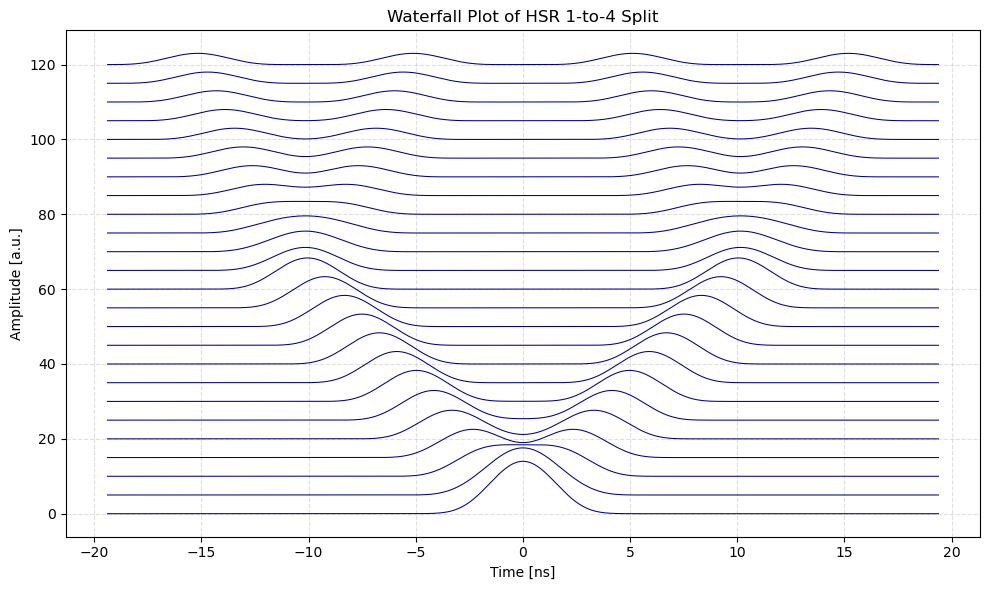

In [15]:
waterfall_plot( test*2, time_ary*1e9, num_waveforms_to_plot=25, xlabel="Time [ns]", ylabel="Amplitude [a.u.]", title="Waterfall Plot of HSR 1-to-4 Split", )

In [81]:
def animate_bunch_splitting(
    waveforms: list[np.ndarray],
    time_array: np.ndarray,
    title: str = "Waterfall Plot of Waveforms",
    xlim: tuple[float, float] = None,
    ylim: tuple[float, float] = None,
    xlabel: str = "Samples",
    ylabel: str = "Amplitude |a.u.|",
    save_file: str = None,
    **kwargs
) -> None:
    fig, ax = plt.subplots()
    line, = ax.plot(time_array, waveforms[0], **kwargs)
    if xlim:
        ax.set_xlim(xlim)
    if ylim:
        ax.set_ylim(ylim)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)

    def update(frame):
        line.set_ydata(waveforms[frame])
        return line,

    ani = animation.FuncAnimation(fig, update, frames=len(waveforms), interval=50, blit=True)
    if save_file:
        ani.save(save_file, writer="pillow", fps=20)

    plt.show()

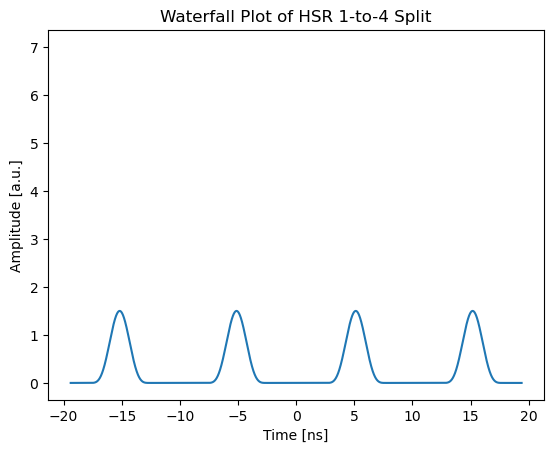

In [90]:
animate_bunch_splitting(test, time_ary*1e9, xlabel="Time [ns]", ylabel="Amplitude [a.u.]", title="Waterfall Plot of HSR 1-to-4 Split", save_file="hsr_1_to_4_split.gif" )

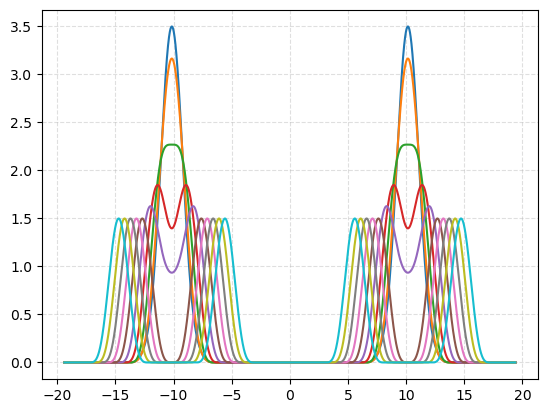

In [328]:
plt.figure()
for i in range(100,200,10):
    plt.plot(time_ary*1e9, test[i])
plt.grid(True, linestyle='--', alpha=0.4)
plt.show()

In [15]:
# --- Bunch lengths
bl_ratio = HSR_PP_BUNCH_LENGTH_23GeV*HSR_RF_24M
split1_bl = HSR_PP_BUNCH_LENGTH_23GeV / 1.5
split2_bl = split1_bl / 1.5

print( f"bunch length = {HSR_PP_BUNCH_LENGTH_23GeV}" )
print( f"bunch length ratio = {bl_ratio}" )
print( f"split1_bl = {split1_bl}" )
print( f"split2_bl = {split2_bl}" )

bunch length = 1.6678204759907602e-09
bunch length ratio = 0.04108044822795375
split1_bl = 1.1118803173271735e-09
split2_bl = 7.412535448847824e-10


In [151]:
turns = 500
dphi = (90*2)/1000

phase_shift = dphi*turns
phase_shift1 = phase_shift if phase_shift < 90.0 else 90.0
phase_shift2 = phase_shift1 if phase_shift <= 90.0 else phase_shift1 - dphi*(turns-500)
phase_shift3 = phase_shift1 if phase_shift <= 90.0 else phase_shift1 + dphi*(turns-500)

print( f"phase_shift = {phase_shift}" )
print( f"phase_shift1 = {phase_shift1}" )
print( f"phase_shift2 = {phase_shift2}" )
print( f"phase_shift3 = {phase_shift3}" )

phase_shift = 90.0
phase_shift1 = 90.0
phase_shift2 = 90.0
phase_shift3 = 90.0


In [147]:
dphi*(turns-500)

0.36

I am starting to figure this out more... I think what I should do is have the the number of steps divided by the number of splits.  The resulting number will be used to transition from 0 to 90. At each step, I can switch to the new frequency for the signals, and then repeat the steps from 0 to 90. 

If we are doing 2X harmonic jumps, then when the when the pulses transition they will be +/- 180*(HF-1) away. 

In [207]:
test_time = np.linspace(-3/(2*np.pi*HSR_RF_24M), 3/(2*np.pi*HSR_RF_24M), 1000)

# --- Initial pulse
init = cosine_square_pulse( test_time, HSR_PP_BUNCH_LENGTH_23GeV, pw_type="rms", phase_freq=HSR_RF_24M)*(1-phase_shift/45.0) if phase_shift<45.0 else np.zeros(test_time.size)

# --- Split 1 --- 2-pulses
#split1 = cosine_square_pulse( test_time, split1_bl, pw_type="rms", phase_freq=HSR_RF_24M, phase_shift=phase_shift1, degrees=True)*(1-phase_shift/135.0) if phase_shift<135.0 else np.zeros(test_time.size)
#split2 = cosine_square_pulse( test_time, split1_bl, pw_type="rms", phase_freq=HSR_RF_24M, phase_shift=-1*phase_shift1, degrees=True )*(1-phase_shift/135.0) if phase_shift<135.0 else np.zeros(test_time.size)

# --- Split 2 --- 4-pulses
split3 = cosine_square_pulse( test_time, split1_bl, pw_type="rms", phase_freq=HSR_RF_98M, phase_shift=(360.0+180), degrees=True )
split4 = cosine_square_pulse( test_time, split1_bl, pw_type="rms", phase_freq=HSR_RF_98M, phase_shift=-1*(360.0+180), degrees=True )
split5 = cosine_square_pulse( test_time, split1_bl, pw_type="rms", phase_freq=HSR_RF_98M, phase_shift=(360.0-180), degrees=True )
split6 = cosine_square_pulse( test_time, split1_bl, pw_type="rms", phase_freq=HSR_RF_98M, phase_shift=-1*(360.0-180), degrees=True )

# sig_test = init + split1 + split2 + split3 + split4 + split5 + split6 
sig_test = init +  split3 + split4 + split5 + split6 

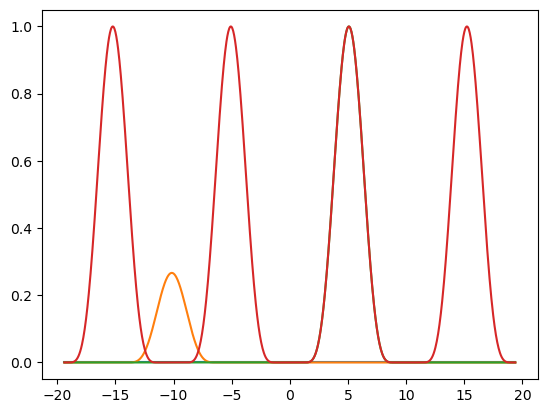

In [208]:
plt.figure()
#plt.plot( test_time*1e9, init+split1+split6 )
plt.plot( test_time*1e9, init )
plt.plot( test_time*1e9, split1 )
plt.plot( test_time*1e9, split6 )
plt.plot( test_time*1e9, sig_test )
plt.show()

In [78]:
test = HSR_PP_BUNCH_LENGTH_23GeV * HSR_RF_24M
print( f"28MHz BL = {HSR_PP_BUNCH_LENGTH_23GeV}")
print( f"28MHz Period = {1/HSR_RF_24M}")
print( f"28MHz BL ratio (BL/Period) = {test}")
print( f"49MHz BL = {test/HSR_RF_49M}")

28MHz BL = 1.6678204759907602e-09
28MHz Period = 4.059888701155576e-08
28MHz BL ratio (BL/Period) = 0.04108044822795375
49MHz BL = 8.339102379953802e-10


In [64]:
split_length = 12
num_splits = 2
dphi = (360*num_splits)/split_length 
print( f"delta phi = {dphi}" )
for turns in range(split_length+1):
    temp = dphi*turns
    phase_shift1 = temp if temp < 360.0 else 360.0
    temp2 = phase_shift1 if temp <= 360.0 else phase_shift1 - ((dphi/4)*turns)
    temp3 = phase_shift1 if temp <= 360.0 else phase_shift1 + ((dphi/4)*turns)
    #print( f"temp = {temp}" )
    print( f"phase1 = {phase_shift1}" )
    print( f"phase2 = {temp2}" )
    print( f"phase3 = {temp3}" )

delta phi = 60.0
phase1 = 0.0
phase2 = 0.0
phase3 = 0.0
phase1 = 60.0
phase2 = 60.0
phase3 = 60.0
phase1 = 120.0
phase2 = 120.0
phase3 = 120.0
phase1 = 180.0
phase2 = 180.0
phase3 = 180.0
phase1 = 240.0
phase2 = 240.0
phase3 = 240.0
phase1 = 300.0
phase2 = 300.0
phase3 = 300.0
phase1 = 360.0
phase2 = 360.0
phase3 = 360.0
phase1 = 360.0
phase2 = 255.0
phase3 = 465.0
phase1 = 360.0
phase2 = 240.0
phase3 = 480.0
phase1 = 360.0
phase2 = 225.0
phase3 = 495.0
phase1 = 360.0
phase2 = 210.0
phase3 = 510.0
phase1 = 360.0
phase2 = 195.0
phase3 = 525.0
phase1 = 360.0
phase2 = 180.0
phase3 = 540.0


### Store
- Normal Store Profiles
- 197 + 591 profile
- Stochastic Cooling profile --> Not available yet, still developing

In [97]:
store_sig = {'PP_41GEV':HSR_SIGS['PP_41GEV'],'PP_100GEV':HSR_SIGS['PP_100GEV'],'PP_275GEV':HSR_SIGS['PP_275GEV'],'AU_41GEV':HSR_SIGS['AU_41GEV'], 'AU_110GEV':HSR_SIGS['AU_110GEV'],}
store_spec = {'PP_41GEV':HSR_SPECS['PP_41GEV'],'PP_100GEV':HSR_SPECS['PP_100GEV'],'PP_275GEV':HSR_SPECS['PP_275GEV'],'AU_41GEV':HSR_SPECS['AU_41GEV'], 'AU_110GEV':HSR_SPECS['AU_110GEV'],}

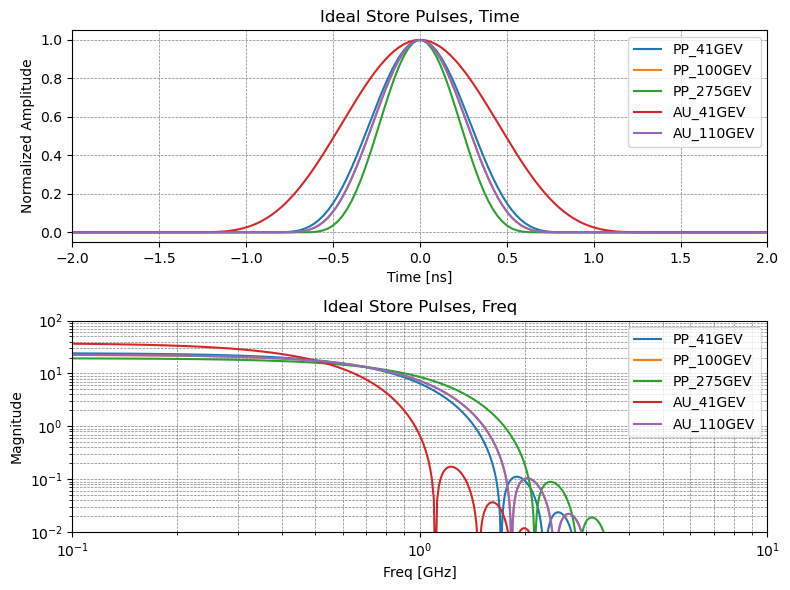

In [100]:
plot_gaus_pulses( time_ary, store_sig, freq_ary, store_spec,
                 ax1_xlim=[-2, 2], title="Ideal Store Pulses",
                 ax2_xlim=[0.1, 10], ax2_ylim=[1e-2, 100], loglog=True,
                 )

Modulated beam Pulse

In [18]:
pp_store_mod = mod_cos_sq_pulse( time_ary, HSR_PP_BUNCH_LENGTH_100GeV*6, HSR_RF_591M, HSR_RF_197M, pulsAmp=1.0, modAmp=1.30, phi=0.0 )
freq_ary, pp_store_mod_spec = get_spectrum( pp_store_mod, Fs )

C:\Users\mpaniccia\AppData\Local\Temp\6\ipykernel_57328\2362264454.py:90: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax1.legend()
C:\Users\mpaniccia\AppData\Local\Temp\6\ipykernel_57328\2362264454.py:101: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax2.legend()


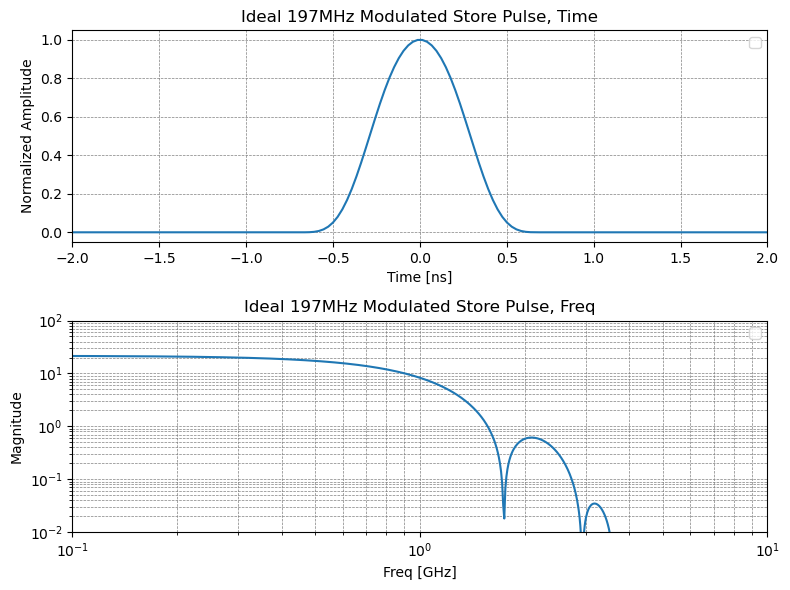

In [19]:
plot_gaus_pulses( time_ary, pp_store_mod, freq_ary, pp_store_mod_spec, 
                 ax1_xlim=[-2, 2], title="Ideal 197MHz Modulated Store Pulse",
                 ax2_xlim=[0.1, 10], ax2_ylim=[1e-2, 100], loglog=True,
                 )

# ESR Profiles

In [2]:
# --- Make signals to test -- ESR Signals
num_bunches = 2
etime_ary = np.linspace(-1*(num_bunches*0.5)/ESR_RF_591M, num_bunches*0.5/ESR_RF_591M, 3000)  # time array for 1 RF cycle

# --- Make ESR Signals
ESR_SIGS = {
    'STORE_5GeV': gaussian_pulse( etime_ary, ESR_BUNCH_LENGTH_5GeV ),
    'STORE_18GeV': gaussian_pulse( etime_ary, ESR_BUNCH_LENGTH_18GeV ),
}

In [3]:
eFs = 1/(etime_ary[1] - etime_ary[0])

# --- Electron Spectrum
ePS_freq, ePS_spec5GeV = get_spectrum( ESR_SIGS['STORE_5GeV'][0], eFs )
__, ePS_spec18GeV = get_spectrum( ESR_SIGS['STORE_18GeV'][0], eFs )

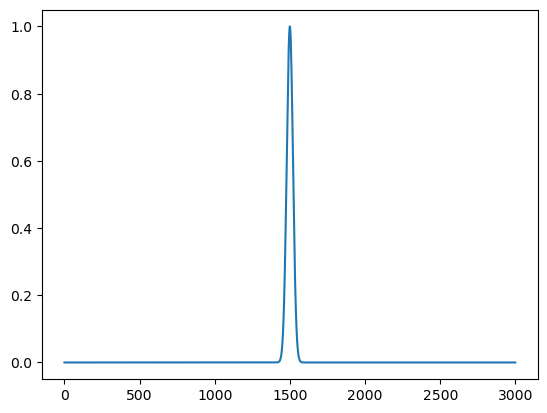

In [4]:
plt.figure()
plt.plot(ESR_SIGS['STORE_5GeV'][0])
plt.show()

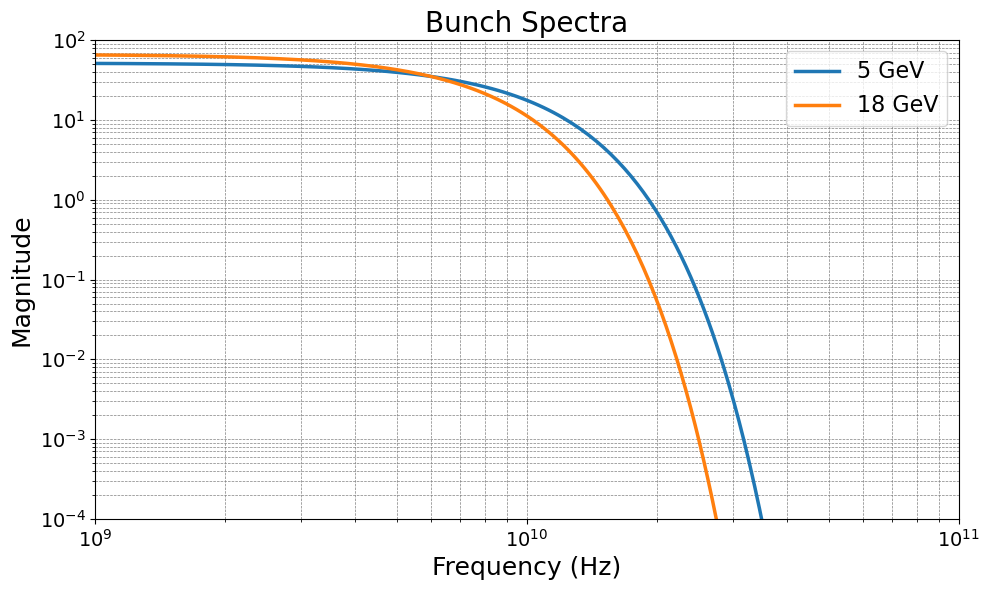

In [8]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(ePS_freq[ePS_freq>0], np.abs(ePS_spec5GeV[ePS_freq>0]), label='5 GeV',linewidth=2.5)
ax.plot(ePS_freq[ePS_freq>0], np.abs(ePS_spec18GeV[ePS_freq>0]), label='18 GeV',linewidth=2.5)
# ax.plot(et_freq[et_freq>0], np.abs(et_spec[et_freq>0]), label='Electrons',linewidth=2.5)
# --- 
ax.set_xlim(1e9, 1e11)
ax.set_ylim(1e-4, 1e2)  # set y-axis limits to log scale
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Frequency (Hz)', fontsize=18)
ax.set_ylabel('Magnitude', fontsize=18)
ax.grid(True, which='both', ls='--', lw=0.5, color='gray')
ax.legend(loc='upper right', fontsize=16)
# --- 
plt.title("Bunch Spectra", fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.show()

In [20]:
a = np.abs(ePS_spec5GeV[ePS_freq>0][np.argmax( np.abs(ePS_spec5GeV[ePS_freq>0]) )])
b = np.abs(ePS_spec5GeV[ePS_freq>0][60] )
print( a )
print( b )
print( 20*np.log10(b/a) )


51.84884085328877
1.572991216294729
-30.36025508265551


In [25]:
(0.5/ESR_BUNCH_LENGTH_5GeV)*1e-9

21.41327623126339

# test

In [41]:
calc_ind_cocentric_cylinders( 6500, 0.161925, 0.073787, 0.2286 )

0.00023356882937324524

In [42]:
calc_cap_cocentric_cylinders( 10, 0.161925, 0.073787 )

7.0783705288347e-10

In [43]:
rpc_resistor = import_spram()

FileNotFoundError: [Errno 2] No such file or directory: '\\'

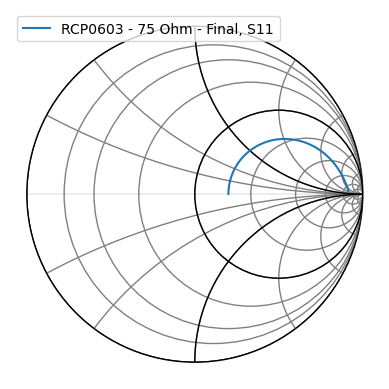

In [ ]:
rpc_resistor.plot_s_smith()

In [ ]:
# Convert to Z-parameters (input impedance)
z = rpc_resistor.z[:, 0, 0]  # Get Z11 over all frequencies
f = rpc_resistor.f  # Frequency array in Hz

# Calculate series inductance from imaginary part of Z
X = np.imag(z)
L_series = X / (2 * np.pi * f)

# Convert Z to admittance (for parallel capacitance extraction)
y = 1 / z
B = np.imag(y)
C_parallel = -B / (2 * np.pi * f)

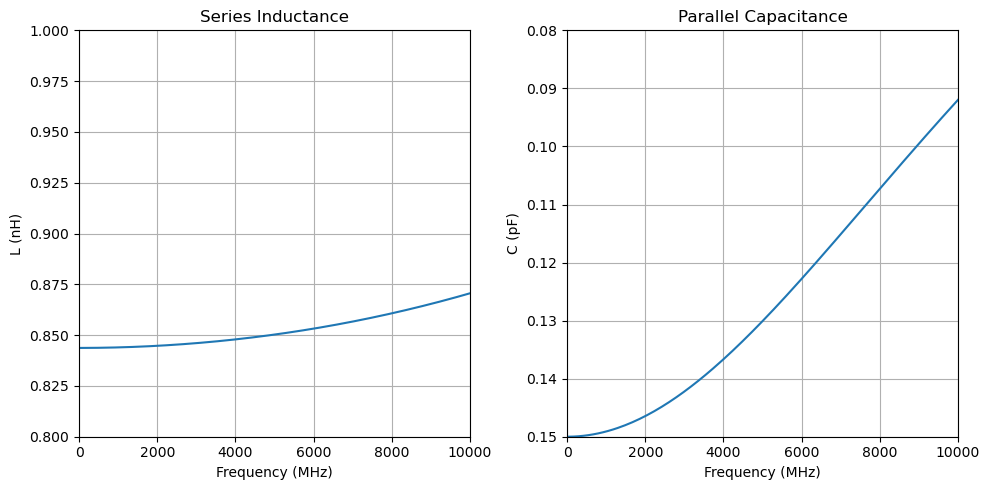

In [ ]:
# Plot results
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(f / 1e6, L_series * 1e9)
plt.grid(True,which='both')
plt.xlim([0, 10000])
plt.ylim([0.8, 1.0])
plt.title("Series Inductance")
plt.xlabel("Frequency (MHz)")
plt.ylabel("L (nH)")

plt.subplot(1, 2, 2)
plt.plot(f / 1e6, C_parallel * 1e12)
plt.grid(True,which='both')
plt.xlim([0, 10000])
plt.ylim([0.15, 0.08])
plt.title("Parallel Capacitance")
plt.xlabel("Frequency (MHz)")
plt.ylabel("C (pF)")

plt.tight_layout()
plt.show()


Text(0, 0.5, 'L (nH)')

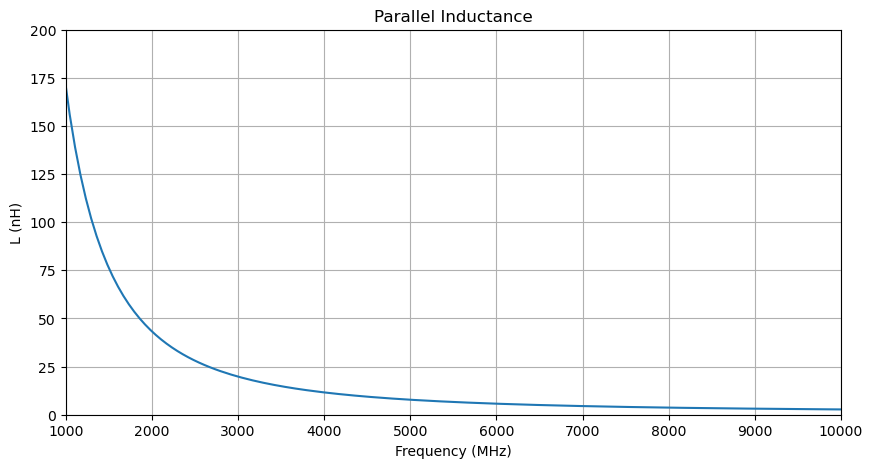

In [ ]:
L_parallel = -1 / (2 * np.pi * f * B)

plt.figure(figsize=(10, 5))
plt.plot(f / 1e6, L_parallel * 1e9)
plt.grid(True,which='both')
plt.xlim([1000, 10000])
plt.ylim([0.00, 200])
plt.title("Parallel Inductance")
plt.xlabel("Frequency (MHz)")
plt.ylabel("L (nH)")


In [87]:
const.epsilon_0

8.8541878128e-12

In [1]:
def inches_to_centimeters(inches):
    """
    Convert inches to centimeters.

    Args:
        inches (float): The value in inches.

    Returns:
        float: The value in centimeters.
    """
    return inches * 2.54

In [4]:
print("8.9950 in = {} cm".format( inches_to_centimeters(8.9950) ) )
print("2.1125 in = {} cm".format( inches_to_centimeters(2.1125) ) )
print("1.3825 in = {} cm".format( inches_to_centimeters(1.3825) ) )
print("1.0000 in = {} cm".format( inches_to_centimeters(1.0000) ) )
print("5.0000 in = {} cm".format( inches_to_centimeters(5.0000) ) )
print("3.5000 in = {} cm".format( inches_to_centimeters(3.5000) ) )
print("5.5000 in = {} cm".format( inches_to_centimeters(5.5000) ) )
print("2.8750 in = {} cm".format( inches_to_centimeters(2.8750) ) )
print("0.0770 in = {} cm".format( inches_to_centimeters(0.0770) ) )
print("0.1250 in = {} cm".format( inches_to_centimeters(0.1250) ) )
print("7.0800 in = {} cm".format( inches_to_centimeters(7.0800) ) )

8.9950 in = 22.847299999999997 cm
2.1125 in = 5.365749999999999 cm
1.3825 in = 3.51155 cm
1.0000 in = 2.54 cm
5.0000 in = 12.7 cm
3.5000 in = 8.89 cm
5.5000 in = 13.97 cm
2.8750 in = 7.3025 cm
0.0770 in = 0.19558 cm
0.1250 in = 0.3175 cm
7.0800 in = 17.9832 cm


In [2]:
calc_cap_cocentric_cylinders( 1.0, 0.14986, 0.073025, 0.203073 )

1.5714931585376497e-11

In [10]:
convert_lengths( [7.995,5.900,2.875],["in"]*3,"m", show=True )

7.995 in = 0.2031 m
5.9 in = 0.1499 m
2.875 in = 0.0730 m


[0.203073, 0.14986, 0.07302499999999999]

In [5]:
calc_ind_cocentric_cylinders( 6500, 0.14986, 0.073025, 0.203073 )

0.00018978584835382684

In [4]:
c1 = calc_cap_parallel_plate( 9.5, 0.00246, 0.003175)
c2 = calc_cap_parallel_plate( 9.5, 0.00246, 0.0039116)
print( "Correct gap = {} pF".format(c1*1e12) )
print( "Modeled gap = {} pF".format(c2*1e12) )
print( "Difference = {} pF".format((c1-c2)*1e12) )

Correct gap = 65.17239974334993 pF
Modeled gap = 52.89967511635546 pF
Difference = 12.272724626994473 pF


[0.50899348 0.12793474 0.46390848 0.79908014 0.31806908 0.17663706
 0.63832277 0.22433699 0.39667619 0.30119745]


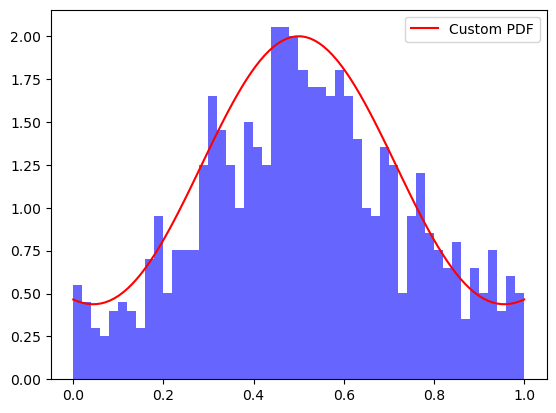

In [52]:
# Define the custom PDF (e.g., a non-standardized bell curve)
def custom_pdf(x):
    return ((1+np.cos(2*(x - 0.5)/0.5)) / 2) + ((1+np.cos(2*(x - 0.5)/0.25)) / 2) # Example: Gaussian-like shape

# Rejection sampling
num_samples = 1000
samples = []
max_pdf_value = custom_pdf(0.5) # Find the peak of the PDF for the bounding box

while len(samples) < num_samples:
    x_candidate = np.random.uniform(0, 1) # Generate x within the range
    y_candidate = np.random.uniform(0, max_pdf_value) # Generate y up to the max PDF value

    if y_candidate <= custom_pdf(x_candidate):
        samples.append(x_candidate)

samples = np.array(samples)
print(samples[:10]) # Print first 10 samples

# Optional: Visualize the distribution
plt.hist(samples, bins=50, density=True, alpha=0.6, color='blue')
x_vals = np.linspace(0, 1, 100)
plt.plot(x_vals, custom_pdf(x_vals), color='red', label='Custom PDF')
plt.legend()
plt.show()

# Function Editing Scratch

In [ ]:
def cosine_squared_pulse(t: np.ndarray, pulse_width: float) -> np.ndarray:
    """
    Generate a cosine-squared pulse.

    Args:
        t (np.ndarray): Time array.
        pulse_width (float): Half-width of the pulse (T), i.e., duration from 0 to peak.

    Returns:
        np.ndarray: Pulse waveform.
    """
    pulse = np.zeros_like(t)
    mask = np.abs(t) <= pulse_width/2
    pulse[mask] = np.cos(np.pi * t[mask] / ( pulse_width)+(15*np.pi/180))**2
    return pulse


In [14]:
def mod_cos_sq_pulse(t: np.ndarray, pulse_width: float, baseF: float, modF: float, pw_type: str = 'fixed', pulsAmp: float = 1.0, modAmp: float = 1.0, phi: float = 0.0) -> np.ndarray:
    """Modulate a cosine square pulse with multiple frequencies.
    
    Args:
        t (np.ndarray): Time array.
        pulse_width (float): Pulse width in seconds. Width is configurable by optional argument `pw_type`.
        baseF (float): Base frequency of the cosine square pulse.
        modF (float): Modulation frequency.
        pw_type (str, optional): Pulse width type. Defaults to 'fixed'.
        pulsAmp (float, optional): Amplitude of the cosine square pulse. Defaults to 1.0.
        modAmp (float, optional): Amplitude of the modulation frequencies. Defaults to 1.0.
        phi (float, optional): Signal phase in degrees. Defaults to 0.
    
    Returns:
        np.ndarray: Modulated cosine square waveform.
    """
    csp = cosine_square_pulse(t, pulse_width, pw_type=pw_type, amplitude=pulsAmp, phi=phi)
    csp_sin = np.sin((baseF)*2*np.pi*t)
    
    mod_sin = modAmp*np.sin((modF)*2*np.pi*t)

    mod_csp = (csp_sin*mod_sin+np.sqrt(modAmp**2+pulsAmp**2))
    mod_csp *= csp
    mod_csp /= mod_csp.max()

    return mod_csp

pulse width = 0.15552235832619166 ns


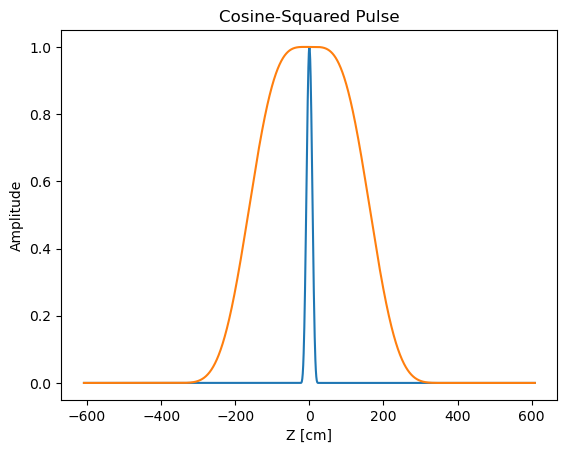

In [74]:
# Time base
t = np.linspace(-0.5/HSR_RF_24M, 0.5/HSR_RF_24M, 2000)

# Generate a cosine-square pulse with 1 µs width
pulse1 = cosine_square_pulse(t, HSR_PP_BUNCH_LENGTH_100GeV, pw_type="rms")
pulse2 = mod_cos_sq_pulse(t, (0.6/HSR_RF_24M), HSR_RF_24M, HSR_RF_49M, modAmp=1 )
print( "pulse width = {} ns".format(calculate_pulse_width(pulse2, (t[1]-t[0]))) )
# Plot

plt.figure()
plt.plot(t * const.c*100, pulse1, t*const.c*100, pulse2 )
# plt.plot(t * 1e6, pulse2 )
plt.title("Cosine-Squared Pulse")
plt.xlabel("Z [cm]")
plt.ylabel("Amplitude")
# plt.xlim([-30, 30])
plt.show()


In [4]:
peaks, s = sg.find_peaks(pulse2)
peak_val, left, right = sg.peak_prominences(pulse2, peaks)
print( t[left] )
print( t[right] )
print( "Absolute width = {} ns".format( abs(t[right] - t[left]) * 1e9 ) )
# sg.peak_widths(pulse2, peaks)


[-5.83900951e-09]
[5.83900951e-09]
Absolute width = [11.67801903] ns


In [92]:
print("24MHz cavity period = {} ns".format((1/HSR_RF_24M)*1e9))
print("PP Store 41GeV = {} ns".format((HSR_PP_BUNCH_LENGTH_41GeV)*7.0e9))
print("PP Store 100GeV = {} ns".format((HSR_PP_BUNCH_LENGTH_100GeV)*7.0e9))
print("PP Store 275GeV = {} ns".format((HSR_PP_BUNCH_LENGTH_275GeV)*7.0e9))
print("Au Store 41GeV = {} ns".format((HSR_AU_BUNCH_LENGTH_41GeV)*7.0e9))
print("Au Store 110GeV = {} ns".format((HSR_AU_BUNCH_LENGTH_110GeV)*7.0e9))

24MHz cavity period = 40.59888701155576 ns
PP Store 41GeV = 1.7512114997902983 ns
PP Store 100GeV = 1.6344640664709453 ns
PP Store 275GeV = 1.4009691998322384 ns
Au Store 41GeV = 2.708540453008995 ns
Au Store 110GeV = 1.6344640664709453 ns


In [7]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Union, Dict, Tuple

def plot_gaus_pulses(
    t: np.ndarray,
    pulses: Union[Dict[str, np.ndarray], np.ndarray],
    freq: np.ndarray,
    pulse_spec: Union[Dict[str, np.ndarray], np.ndarray],
    title: str = None,
    ax1_xlabel: str = None,
    ax1_ylabel: str = None,
    ax1_xlim: Tuple[float, float] = None,
    ax1_ylim: Tuple[float, float] = None,
    ax2_xlabel: str = None,
    ax2_ylabel: str = None,
    ax2_xlim: Tuple[float, float] = None,
    ax2_ylim: Tuple[float, float] = None,
    grid: bool = True,
    legend: bool = True,
    loglog: bool = False,
    figsize: Tuple[int, int] = (8, 6),
    dpi: int = 100,
    **kwargs
) -> None:
    """
    Plot Gaussian pulses in time and frequency domains.

    Parameters:
    t (np.ndarray): Time array
    pulses (Union[Dict[str, np.ndarray], np.ndarray]): Dictionary of pulse values or single pulse array
    freq (np.ndarray): Frequency array
    pulse_spec (Union[Dict[str, np.ndarray], np.ndarray]): Dictionary of pulse spectra or single pulse spectrum array
    title (str, optional): Plot title. Defaults to None.
    ax1_xlabel (str, optional): X-axis label for time plot. Defaults to None.
    ax1_ylabel (str, optional): Y-axis label for time plot. Defaults to None.
    ax1_xlim (Tuple[float, float], optional): X-axis limits for time plot. Defaults to None.
    ax1_ylim (Tuple[float, float], optional): Y-axis limits for time plot. Defaults to None.
    ax2_xlabel (str, optional): X-axis label for frequency plot. Defaults to None.
    ax2_ylabel (str, optional): Y-axis label for frequency plot. Defaults to None.
    ax2_xlim (Tuple[float, float], optional): X-axis limits for frequency plot. Defaults to None.
    ax2_ylim (Tuple[float, float], optional): Y-axis limits for frequency plot. Defaults to None.
    grid (bool, optional): Show grid. Defaults to True.
    legend (bool, optional): Show legend. Defaults to True.
    loglog (bool, optional): Use log-log scale for frequency plot. Defaults to False.
    figsize (Tuple[int, int], optional): Figure size. Defaults to (8, 6).
    dpi (int, optional): Figure DPI. Defaults to 100.
    **kwargs: Additional keyword arguments for plot customization

    Returns:
    None
    """
    tt = t*1e9  # Convert time to nanoseconds
    ff = freq*1e-9  # Convert frequency to GHz

    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=figsize, dpi=dpi)

    if isinstance(pulses, dict):
        for p in pulses.keys():
            # sigma = calculate_pulse_width(pulses[p], t[1] - t[0]) / 1e9
            # ax1.plot(tt, pulses[p], label=label or f"$\\sigma$={sigma*const.c*100:.2f}cm")
            ax1.plot(tt, pulses[p], label=p)
            if loglog:
                ax2.loglog(ff, np.abs(pulse_spec[p]), label=p)
                        #    label=label or f"$\\sigma$={sigma*const.c*100:.2f}cm")
                            
            else:
                ax2.plot(ff, np.abs(pulse_spec[p]),label=p)
                        #  label=label or f"$\\sigma$={sigma*const.c*100:.2f}cm")
    else:
        # sigma = calculate_pulse_width(pulses, t[1] - t[0]) / 1e9
        ax1.plot(tt, pulses, )
                #  label=label or f"$\\sigma$={sigma*const.c*100:.2f}cm")
        if loglog:
            ax2.loglog(ff, np.abs(pulse_spec), )
                    #    label=label or f"$\\sigma$={sigma*const.c*100:.2f}cm")
        else:
            ax2.plot(ff, np.abs(pulse_spec), )
                    #  label=label or f"$\\sigma$={sigma*const.c*100:.2f}cm")
            
    ax1.grid(axis="both", which="both" if grid else "none", ls='--', lw=0.5, color='gray')
    ax1.set_xlabel(ax1_xlabel or "Time [ns]")
    ax1.set_ylabel(ax1_ylabel or "Normalized Amplitude")
    ax1.set_title(title+", Time" or 'Ideal Beam Pulse, Time')
    if ax1_xlim:
        ax1.set_xlim(ax1_xlim)
    if ax1_ylim:
        ax1.set_ylim(ax1_ylim)
    if legend:
        ax1.legend()

    ax2.grid(axis="both", which="both" if grid else "none", ls='--', lw=0.5, color='gray')
    ax2.set_xlabel(ax2_xlabel or "Freq [GHz]")
    ax2.set_ylabel(ax2_ylabel or "Magnitude")
    ax2.set_title(title+", Freq" or 'Ideal Beam Pulse, Freq.')
    if ax2_xlim:
        ax2.set_xlim(ax2_xlim)
    if ax2_ylim:
        ax2.set_ylim(ax2_ylim)
    if legend:
        ax2.legend()

    plt.tight_layout()
    plt.show()

In [ ]:
def create_transition_array(
        length: int,
        values: Tuple[float,float],
        change_points: Union[Tuple[int,int], List[int], int],
        transition_lengths: Union[Tuple[int,int], List[int], int],
        ) -> np.ndarray:
    """
    Create an array with transitions to different values based on the provided parameters.

    Args:
        length (int): Number of turns in the array.
        values (tuple): Tuple containing the values to transition to.
        change_points (tuple, list, or int): Turn numbers where the array changes values.
        transition_lengths (tuple, list, or int): Number of turns it takes to transition to the new value.

    Returns:
        np.ndarray: Array with transitions to different values.
    """

    # Normalize change_points and transition_lengths to lists
    if isinstance(change_points, (int, float)):
        change_points = [change_points] * (len(values) - 1)
    elif isinstance(change_points, (tuple, list)):
        change_points = list(change_points)

    if isinstance(transition_lengths, (int, float)):
        transition_lengths = [transition_lengths] * (len(values) - 1)
    elif isinstance(transition_lengths, (tuple, list)):
        transition_lengths = list(transition_lengths)

    # Validate input lengths
    if len(values) != len(change_points) + 1 or len(change_points) != len(transition_lengths):
        raise ValueError("Invalid input lengths. Ensure len(values) = len(change_points) + 1 and len(change_points) = len(transition_lengths).")

    # Initialize the array
    array = np.zeros(length)
    current_value = values[0]

    # Fill up to first change point
    array[:change_points[0]] = current_value

    # Apply transitions
    for i in range(len(change_points)):
        start = change_points[i]
        end = min(start + transition_lengths[i], length)
        next_value = values[i + 1]

        # Create linear transition
        transition = np.linspace(current_value, next_value, end - start, endpoint=False)
        array[start:end] = transition

        current_value = next_value

        # Fill the next flat section (if any)
        if i < len(change_points) - 1:
            next_cp = change_points[i + 1]
            if end < next_cp:
                array[end:next_cp] = current_value
        else:
            # Fill the remainder of the array
            if end < length:
                array[end:] = current_value

    return array

In [40]:
def waterfall_plot(
    waveforms: list[np.ndarray],
    time_array: np.ndarray,
    num_waveforms_to_plot: int = 50,
    amplitude_scaling: int = 5,
    title: str = "Waterfall Plot of Waveforms",
    xlim: tuple[float, float] = None,
    ylim: tuple[float, float] = None,
    xlabel: str = "Time (Samples)",
    ylabel: str = "Amplitude + Offset",
    figsize: tuple[int, int] = (10, 6),
    **kwargs
) -> None:
    """
    Creates a waterfall plot of a subset of waveforms from a list.

    Args:
        waveforms: A list of numpy arrays, where each array represents a waveform.
        time_array: A numpy array representing the time values for the waveforms.
        num_waveforms_to_plot: The number of evenly spaced waveforms to display.
        title: The title of the plot.
        xlim: The x-axis limits (tuple of two floats).
        ylim: The y-axis limits (tuple of two floats).
        xlabel: The x-axis label.
        ylabel: The y-axis label.
        figsize: The figure size (tuple of two ints).

    Raises:
        ValueError: If num_waveforms_to_plot exceeds the total number of waveforms.

    Returns:
        None
    """

    num_total_waveforms = len(waveforms)

    if num_waveforms_to_plot > num_total_waveforms:
        raise ValueError("Number of waveforms to plot cannot exceed the total number of waveforms.")

    indices = np.linspace(0, num_total_waveforms - 1, num_waveforms_to_plot, dtype=int)
    selected_waveforms = [waveforms[i] for i in indices]

    plt.figure(figsize=figsize)

    for i, waveform in enumerate(selected_waveforms):
        plt.plot(time_array, waveform + i * amplitude_scaling, linewidth=0.75, color='darkblue', **kwargs) # Add offset to each waveform

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if xlim:
        plt.xlim(xlim)
    if ylim:
        plt.ylim(ylim)
    plt.grid(True, linestyle='--', alpha=0.4)
    plt.tight_layout()
    plt.show()


In [243]:
# --- Constants
harmonic_number = 1  # Fundamental harmonic
V_rf = 1e3           # RF voltage [V]
phi_s = np.pi / 2    # Synchronous phase [rad]
q = 1.6e-19          # Particle charge [C]
E0 = 1e6 * q         # Reference energy [J]
beta = 0.9           # v/c
eta = 0.01           # Slip factor
T_rev = 1e-6         # Revolution period [s]

# --- Time and Energy coordinates
phi = np.linspace(-3*np.pi, 3*np.pi, 5000)  # Phase in RF bucket
dE = np.linspace(-2 * E0, 2 * E0, 5000)  # Energy deviation

# --- Meshgrid for plotting
PHI, DE = np.meshgrid(phi, dE)

# --- Hamiltonian (longitudinal equation of motion)
H = 0.5 * (eta / (beta ** 2 * E0)) * (DE) ** 2 - q * V_rf / (2 * np.pi * harmonic_number) * (
    np.cos(PHI) + PHI * np.sin(phi_s)
)

# # --- Plot the separatrix
# plt.figure(figsize=(8, 6))
# plt.contour(PHI, DE / q / 1e3, H, levels=[0], colors='red', linewidths=2, linestyles='--',)# label='Separatrix')
# plt.xlabel('RF Phase [rad]')
# plt.ylabel('Energy Deviation [keV]')
# plt.title('Longitudinal Phase Space and RF Separatrix')
# plt.grid(True)

# DOES NOT WORK
# # --- Example particles collecting in the separatrix
# num_particles = 1000
# initial_phi = np.random.uniform(-np.pi, np.pi, num_particles)
# initial_dE = np.random.uniform(-1 * E0, 1 * E0, num_particles)

# plt.scatter(initial_phi, initial_dE / q / 1e3, color='blue', s=10, alpha=0.7, label='Particles')
# plt.legend()
# plt.show()


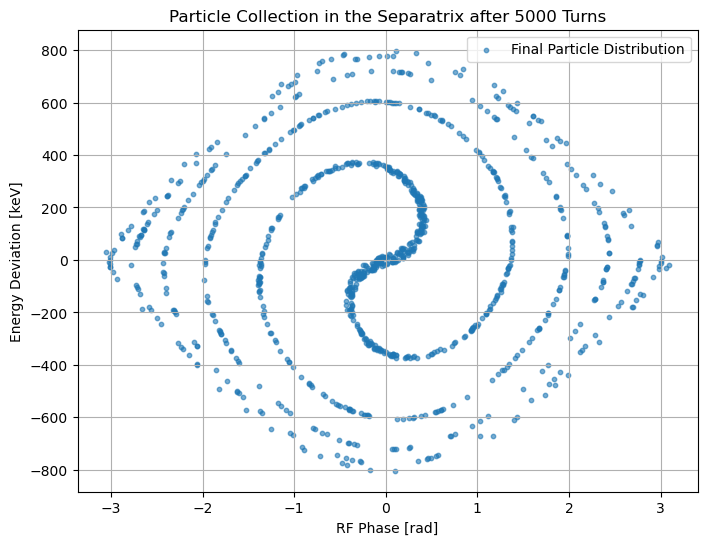

In [250]:
# --- RF and machine parameters
V_rf = 2000             # RF voltage [V]
phi_s = 0               # Synchronous phase [rad]
q = 1.6e-19             # Charge [C]
E0 = 1e6 * q            # Reference energy [J]
beta = 0.9
eta = 0.01
h = 1                   # Harmonic number
omega_rf = 2 * np.pi * 500e6  # RF frequency [rad/s]

# --- Derived quantities
U0 = q * V_rf           # Maximum energy gain per turn [J]
omega_s = np.sqrt((q * V_rf * np.cos(phi_s) * h * omega_rf * eta) / (2 * np.pi * beta ** 2 * E0))  # Synchrotron freq

# --- Initialize particles
N_particles = 1000
phi = np.random.uniform(-np.pi, np.pi, N_particles)
dE = np.random.uniform(-0.02 * E0, 0.02 * E0, N_particles)

# --- Simulation settings
turns = 5000
phi_list = []
dE_list = []

# --- Track particles
for turn in range(turns):
    # Half energy kick
    dE += -q * V_rf * np.sin(phi) / 2

    # Phase advance
    phi += eta * dE / (beta**2 * E0)

    # Full energy kick
    dE += -q * V_rf * np.sin(phi) / 2

    # Wrap phase to [-pi, pi]
    phi = (phi + np.pi) % (2 * np.pi) - np.pi

    # Save for plotting (optional, or just the final state)
    if turn % 50 == 0:
        phi_list.append(phi.copy())
        dE_list.append(dE.copy())

# --- Plot final distribution
plt.figure(figsize=(8, 6))
plt.scatter(phi, dE / q / 1e3, s=10, alpha=0.6, label='Final Particle Distribution')
plt.xlabel('RF Phase [rad]')
plt.ylabel('Energy Deviation [keV]')
plt.title(f'Particle Collection in the Separatrix after {turns} Turns')
plt.grid(True)
plt.legend()
plt.show()


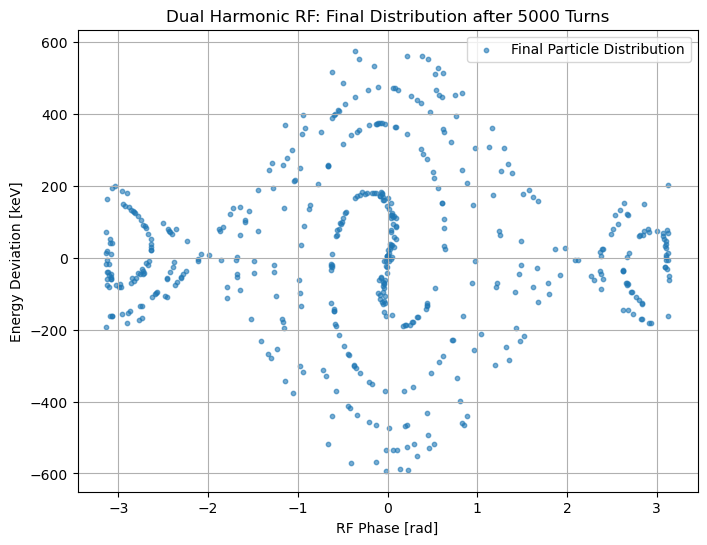

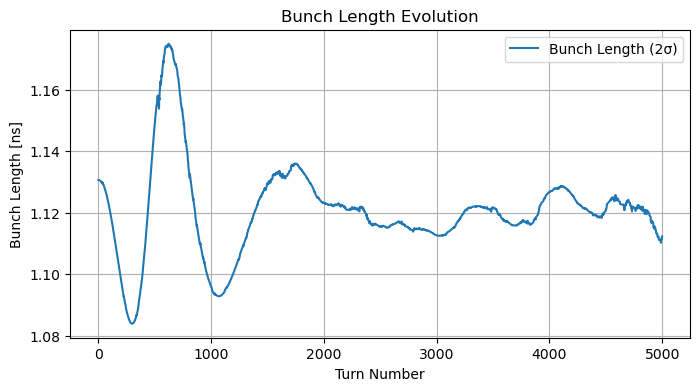

In [254]:
# --- RF and machine parameters
V1 = 1000            # Fundamental RF voltage [V]
V2 = 1000             # Second harmonic RF voltage [V]
h1 = 1               # Fundamental harmonic number
h2 = 2               # Second harmonic number
phi_s = 0            # Synchronous phase [rad]

q = 1.6e-19          # Charge [C]
E0 = 1e6 * q         # Reference energy [J]
beta = 0.9
eta = 0.01
f_rf = 500e6         # RF frequency [Hz]

# --- Initialize particles
N_particles = 500
phi = np.random.uniform(-np.pi, np.pi, N_particles)
dE = np.random.uniform(-0.02 * E0, 0.02 * E0, N_particles)

# --- Simulation settings
turns = 5000
bunch_length_history = []

# --- Tracking loop
for turn in range(turns):
    # Half energy kick from both RF systems
    dE += -q * (V1 * np.sin(h1 * phi) + V2 * np.sin(h2 * phi)) / 2

    # Phase advance
    phi += eta * dE / (beta ** 2 * E0)

    # Full energy kick from both RF systems
    dE += -q * (V1 * np.sin(h1 * phi) + V2 * np.sin(h2 * phi)) / 2

    # Keep phi in [-pi, pi]
    phi = (phi + np.pi) % (2 * np.pi) - np.pi

    # --- Bunch length: 2 * standard deviation of phase converted to time
    bunch_length_phase = np.std(phi) * 2  # Approx. 2-sigma phase spread
    bunch_length_time = bunch_length_phase / (2 * np.pi * f_rf)  # Convert to seconds
    bunch_length_history.append(bunch_length_time * 1e9)  # Save in ns

# --- Plot final distribution
plt.figure(figsize=(8, 6))
plt.scatter(phi, dE / q / 1e3, s=10, alpha=0.6, label='Final Particle Distribution')
plt.xlabel('RF Phase [rad]')
plt.ylabel('Energy Deviation [keV]')
plt.title(f'Dual Harmonic RF: Final Distribution after {turns} Turns')
plt.grid(True)
plt.legend()
plt.show()

# --- Plot bunch length over turns
plt.figure(figsize=(8, 4))
plt.plot(bunch_length_history, label="Bunch Length (2σ)")
plt.xlabel('Turn Number')
plt.ylabel('Bunch Length [ns]')
plt.title('Bunch Length Evolution')
plt.grid(True)
plt.legend()
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass, asdict
import pandas as pd
from pathlib import Path
from typing import Optional, Sequence, Dict, Any

# ------------------------------------------------------------
# Data containers
# ------------------------------------------------------------
@dataclass
class RFParams:
    V1: float                # Fundamental RF voltage [V]
    h1: int = 1              # Fundamental harmonic number
    V2: float = 0.0          # 2nd RF voltage [V] (0 disables)
    h2: int = 2              # 2nd harmonic number
    phi_s: float = 0.0       # Synchronous phase [rad]
    phi2_rel: float = 0.0    # Phase offset of 2nd harmonic wrt fundamental [rad]
    f_rf: float = 500e6      # Fundamental RF frequency [Hz]

@dataclass
class MachineParams:
    q: float = 1.602e-19     # Charge [C]
    E0_J: float = 1e6 * 1.602e-19  # Reference kinetic energy [J]
    beta: float = 0.9        # v/c
    eta: float = 0.01        # Slip factor

@dataclass
class DampingNoiseParams:
    damp_phi: float = 0.0    # fractional damping/turn of phase deviation from sync
    damp_dE: float = 0.0     # fractional damping/turn of energy deviation
    noise_phi_rms: float = 0.0 # [rad RMS/turn]
    noise_dE_rms_eV: float = 0.0 # [eV RMS/turn]

# ------------------------------------------------------------
# Core kick functions
# ------------------------------------------------------------
def rf_energy_kick(phi, rf: RFParams, q: float):
    """Return energy kick [J] from RF systems at given phases."""
    kick = rf.V1 * np.sin(rf.h1 * phi - rf.phi_s)
    if rf.V2 != 0.0:
        kick += rf.V2 * np.sin(rf.h2 * phi - rf.phi_s * rf.h2 + rf.phi2_rel)
    return -q * kick  # minus sign = stable phase at +sin slope region convention

def phase_advance(phi, dE, mach: MachineParams):
    """Advance phase using slip factor coupling."""
    return phi + mach.eta * dE / (mach.beta**2 * mach.E0_J)

def wrap_phase(phi):
    """Wrap to [-pi, pi]."""
    return (phi + np.pi) % (2 * np.pi) - np.pi

# ------------------------------------------------------------
# Diagnostics
# ------------------------------------------------------------
def phase_to_time(phi, rf: RFParams):
    """Convert RF phase [rad] to time offset [s] relative to synchronous particle."""
    return phi / (2 * np.pi * rf.f_rf)

def energy_J_to_eV(dE_J, q):
    return dE_J / q

def rms_bunch_length(phi, rf: RFParams):
    z = phase_to_time(phi, rf)
    return np.std(z)

def rms_energy_spread(dE_J, q):
    return np.std(energy_J_to_eV(dE_J, q))

def rms_longitudinal_emittance(phi, dE_J, rf: RFParams, mach: MachineParams):
    """
    RMS longitudinal emittance via covariance determinant.
    Returns:
        eps_rms (float): sqrt(det(cov))) in eV*s
        area_1sigma (float): pi * eps_rms (phase-space ellipse area)
    """
    z = phase_to_time(phi, rf)                        # [s]
    dE_eV = energy_J_to_eV(dE_J, mach.q)              # [eV]
    arr = np.vstack((z, dE_eV))
    cov = np.cov(arr)                                 # 2x2
    det_cov = np.linalg.det(cov)
    det_cov = max(det_cov, 0.0)                       # numeric safety
    eps_rms = np.sqrt(det_cov)                        # [s * eV]
    area_1sigma = np.pi * eps_rms                     # ellipse area
    return eps_rms, area_1sigma

# ------------------------------------------------------------
# Tracking
# ------------------------------------------------------------
def track_longitudinal(
    N_particles: int,
    turns: int,
    rf: RFParams,
    mach: MachineParams,
    damp_noise: DampingNoiseParams = DampingNoiseParams(),
    phi0: Optional[np.ndarray] = None,
    dE0_J: Optional[np.ndarray] = None,
    sample_interval: int = 10,
    export_path: Optional[str] = None,
    export_snapshots: bool = True,
    rng: Optional[np.random.Generator] = None,
) -> Dict[str, Any]:
    """
    Track particles longitudinally in an RF bucket with optional 2nd harmonic,
    damping, and random noise kicks.

    Args:
        N_particles: Number of macro-particles.
        turns: Number of turns to track.
        rf: RFParams instance.
        mach: MachineParams instance.
        damp_noise: DampingNoiseParams instance.
        phi0: Initial phase array [rad]; if None random uniform in [-pi,pi].
        dE0_J: Initial energy deviation [J]; if None random uniform small band.
        sample_interval: Save diagnostics every N turns.
        export_path: Folder path to write outputs (CSV + NPZ).
        export_snapshots: If True, store sampled phi,dE arrays.
        rng: Optional np.random.Generator for reproducibility.

    Returns:
        dict with history arrays + final particle state.
    """
    if rng is None:
        rng = np.random.default_rng()

    # --- Init particles
    if phi0 is None:
        phi = rng.(-np.pi, np.pi, N_particles)
    else:
        phi = np.array(phi0, dtype=float)

    if dE0_J is None:
        # ±2% energy spread band (editable)
        dE = rng.uniform(-0.02 * mach.E0_J, 0.02 * mach.E0_J, N_particles)
    else:
        dE = np.array(dE0_J, dtype=float)

    # --- Noise scaling
    noise_phi_rms = damp_noise.noise_phi_rms
    noise_dE_rms_J = damp_noise.noise_dE_rms_eV * mach.q  # convert eV to J

    # --- Storage
    turns_recorded = []
    bunch_len_ns = []
    sigma_E_keV = []
    eps_eVs = []
    eps_area = []
    snapshots_phi = []
    snapshots_dE = []

    # --- Tracking loop
    for turn in range(turns):
        # Half RF kick
        dE += 0.5 * rf_energy_kick(phi, rf, mach.q)

        # Apply damping (energy half-step)
        if damp_noise.damp_dE != 0.0:
            dE *= (1.0 - damp_noise.damp_dE)

        # Phase advance
        phi = phase_advance(phi, dE, mach)

        # Apply damping (phase advance step about synchronous phase=0)
        if damp_noise.damp_phi != 0.0:
            phi *= (1.0 - damp_noise.damp_phi)

        # Wrap
        phi = wrap_phase(phi)

        # Full RF kick
        dE += 0.5 * rf_energy_kick(phi, rf, mach.q)

        # Damping again (energy)
        if damp_noise.damp_dE != 0.0:
            dE *= (1.0 - damp_noise.damp_dE)

        # Add noise
        if noise_phi_rms > 0.0:
            phi += rng.normal(scale=noise_phi_rms, size=N_particles)
            phi = wrap_phase(phi)
        if noise_dE_rms_J > 0.0:
            dE += rng.normal(scale=noise_dE_rms_J, size=N_particles)

        # Sample diagnostics
        if (turn % sample_interval) == 0 or (turn == turns - 1):
            turns_recorded.append(turn)

            # Stats
            sig_z = rms_bunch_length(phi, rf)            # [s]
            sig_E = rms_energy_spread(dE, mach.q)        # [eV]
            eps_rms, area_1sigma = rms_longitudinal_emittance(phi, dE, rf, mach)

            bunch_len_ns.append(2 * sig_z * 1e9)         # report 2σ in ns
            sigma_E_keV.append(sig_E / 1e3)              # keV
            eps_eVs.append(eps_rms)                      # eV*s
            eps_area.append(area_1sigma)                 # eV*s (area)

            if export_snapshots:
                snapshots_phi.append(phi.copy())
                snapshots_dE.append(dE.copy())

    # --- Package results
    stats_df = pd.DataFrame({
        "turn": turns_recorded,
        "bunch_length_2sigma_ns": bunch_len_ns,
        "sigma_E_keV": sigma_E_keV,
        "eps_rms_eVs": eps_eVs,
        "eps_area1sigma_eVs": eps_area,
    })

    results = {
        "stats": stats_df,
        "final_phi": phi,
        "final_dE_J": dE,
        "snapshots_phi": snapshots_phi if export_snapshots else None,
        "snapshots_dE_J": snapshots_dE if export_snapshots else None,
        "rf": asdict(rf),
        "machine": asdict(mach),
        "damp_noise": asdict(damp_noise),
    }

    # --- Export if requested
    if export_path is not None:
        p = Path(export_path)
        p.mkdir(parents=True, exist_ok=True)
        # CSV stats
        stats_df.to_csv(p / "longitudinal_stats.csv", index=False)
        # NPZ snapshots
        if export_snapshots:
            np.savez_compressed(
                p / "longitudinal_snapshots.npz",
                turns=np.array(turns_recorded),
                snapshots_phi=np.array(snapshots_phi, dtype=object),
                snapshots_dE_J=np.array(snapshots_dE, dtype=object),
                rf=asdict(rf),
                machine=asdict(mach),
                damp_noise=asdict(damp_noise),
            )

    return results



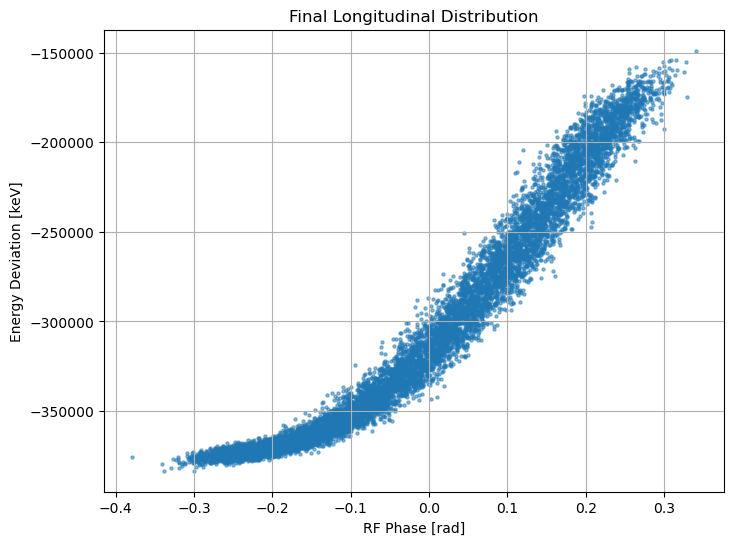

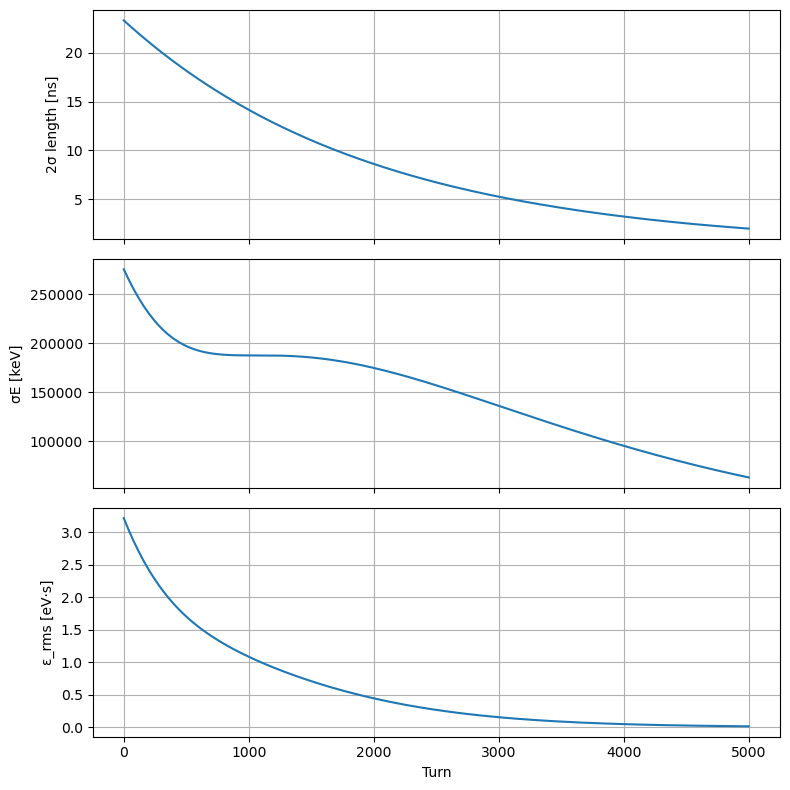

In [41]:
# ------------------------------------------------------------
# Quick demo
# ------------------------------------------------------------
rf = RFParams(
    V1=0.4e6,
    h1=1,
    V2=0.0,    # try 0.0 to disable 2nd harmonic
    h2=2,
    phi_s=180.0,
    phi2_rel=0.0,
    f_rf=24.80e6,
)
mach = MachineParams(
    q=1.602e-19,
    E0_J=23.8e9 * 1.602e-19,
    beta=0.999223,
    eta=0.00037,
)
damp_noise = DampingNoiseParams(
    damp_phi=0.0005,          # ~0.05%/turn phase damping
    damp_dE=0.0005,           # ~0.05%/turn energy damping
    noise_phi_rms=1e-3,       # rad
    noise_dE_rms_eV=5.0,      # eV/turn
)

res = track_longitudinal(
    N_particles=10000,
    turns=5000,
    rf=rf,
    mach=mach,
    damp_noise=damp_noise,
    sample_interval=20,
    export_path="longitudinal_run",
    export_snapshots=True,
)

# --- Plot final distribution
phi = res["final_phi"]
dE_J = res["final_dE_J"]
dE_keV = energy_J_to_eV(dE_J, mach.q) / 1e3

plt.figure(figsize=(8, 6))
plt.scatter(phi, dE_keV, s=5, alpha=0.5)
plt.xlabel("RF Phase [rad]")
plt.ylabel("Energy Deviation [keV]")
plt.title("Final Longitudinal Distribution")
plt.grid(True)
plt.show()

# --- Plot evolution stats
stats = res["stats"]
fig, ax = plt.subplots(3, 1, figsize=(8, 8), sharex=True)
ax[0].plot(stats["turn"], stats["bunch_length_2sigma_ns"])
ax[0].set_ylabel("2σ length [ns]")
ax[0].grid(True)
ax[1].plot(stats["turn"], stats["sigma_E_keV"])
ax[1].set_ylabel("σE [keV]")
ax[1].grid(True)
ax[2].plot(stats["turn"], stats["eps_rms_eVs"])
ax[2].set_ylabel("ε_rms [eV·s]")
ax[2].set_xlabel("Turn")
ax[2].grid(True)
plt.tight_layout()
plt.show()


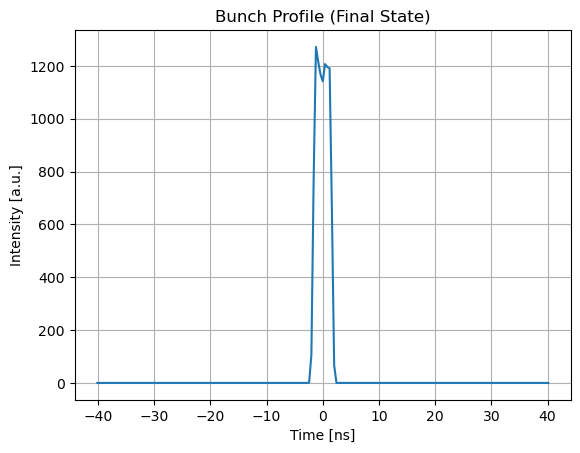

In [42]:
phi = res["final_phi"]  # From the tracking results
f_rf = rf.f_rf

# Convert phase to time
t = phi / (2 * np.pi * f_rf)  # [s]

# Create histogram
bins = np.linspace(-1/f_rf, 1/f_rf, 200)  # One RF period
hist, edges = np.histogram(t, bins=bins)
bin_centers = 0.5 * (edges[:-1] + edges[1:])

# Plot profile
import matplotlib.pyplot as plt
plt.plot(bin_centers * 1e9, hist)
plt.xlabel("Time [ns]")
plt.ylabel("Intensity [a.u.]")
plt.title("Bunch Profile (Final State)")
plt.grid(True)
plt.show()


In [29]:
snapshots_phi = res["snapshots_phi"]
profiles = []
bins = np.linspace(-1/rf.f_rf, 1/rf.f_rf, 200)

for phi_snap in snapshots_phi:
    t_snap = phi_snap / (2 * np.pi * rf.f_rf)
    hist, _ = np.histogram(t_snap, bins=bins)
    profiles.append(hist)

profiles = np.array(profiles)  # Shape: (n_snapshots, n_bins)


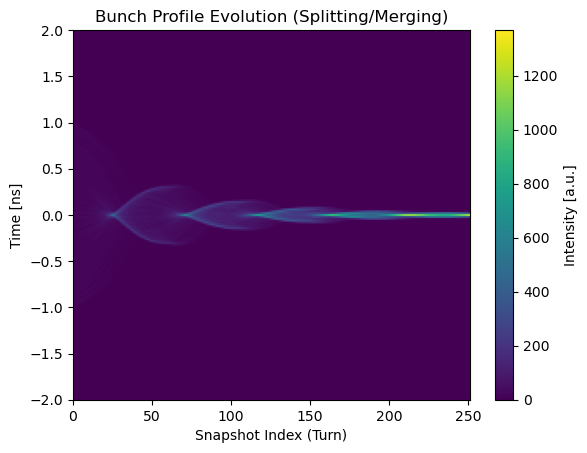

In [30]:
plt.imshow(
    profiles.T,
    aspect='auto',
    extent=[0, len(snapshots_phi), bins[0]*1e9, bins[-1]*1e9],
    origin='lower',
    cmap='viridis'
)
plt.colorbar(label="Intensity [a.u.]")
plt.xlabel("Snapshot Index (Turn)")
plt.ylabel("Time [ns]")
plt.title("Bunch Profile Evolution (Splitting/Merging)")
plt.show()


In [31]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Callable, Optional, Dict, Any

def track_longitudinal_with_profiles(
    N_particles: int,
    turns: int,
    rf,
    mach,
    damp_noise=None,
    phi0=None,
    dE0_J=None,
    sample_interval: int = 10,
    profile_bins: int = 200,
    rf_schedule: Optional[Dict[str, Callable[[int], float]]] = None,
    export_path: Optional[str] = None,
    rng=None
) -> Dict[str, Any]:
    """
    Track particles with optional dual-harmonic RF, RF schedule, and bunch profile output.

    Args:
        N_particles: Number of macro-particles.
        turns: Number of turns to track.
        rf: RFParams object (or similar with attributes V1, V2, f_rf, etc.).
        mach: MachineParams object.
        damp_noise: DampingNoiseParams object (optional).
        phi0, dE0_J: Initial phase and energy arrays.
        sample_interval: Save diagnostics every N turns.
        profile_bins: Number of bins for bunch profile histogram.
        rf_schedule: Optional dict of callables { 'V1': func(turn), 'V2': func(turn), ... }.
        export_path: Folder to export results (optional).
        rng: Random number generator (np.random.Generator).

    Returns:
        dict with stats, bunch profiles, and final states.
    """
    if rng is None:
        rng = np.random.default_rng()

    # --- Initialize particles
    phi = rng.uniform(-np.pi, np.pi, N_particles) if phi0 is None else np.array(phi0, float)
    dE = rng.uniform(-0.02 * mach.E0_J, 0.02 * mach.E0_J, N_particles) if dE0_J is None else np.array(dE0_J, float)

    # --- Setup bins for bunch profiles (time projection)
    time_bins = np.linspace(-1/rf.f_rf, 1/rf.f_rf, profile_bins)
    bin_centers = 0.5 * (time_bins[:-1] + time_bins[1:])

    turns_recorded, profiles, stats = [], [], []

    for turn in range(turns):
        # Apply RF schedule if provided
        if rf_schedule:
            for attr, func in rf_schedule.items():
                setattr(rf, attr, func(turn))

        # --- Half RF kick
        dE += 0.5 * rf_energy_kick(phi, rf, mach.q)

        # --- Damping
        if damp_noise and damp_noise.damp_dE:
            dE *= (1.0 - damp_noise.damp_dE)

        # --- Phase advance
        phi = phase_advance(phi, dE, mach)

        if damp_noise and damp_noise.damp_phi:
            phi *= (1.0 - damp_noise.damp_phi)

        phi = wrap_phase(phi)

        # --- Full RF kick
        dE += 0.5 * rf_energy_kick(phi, rf, mach.q)
        if damp_noise and damp_noise.damp_dE:
            dE *= (1.0 - damp_noise.damp_dE)

        # --- Noise
        if damp_noise and damp_noise.noise_phi_rms > 0:
            phi += rng.normal(scale=damp_noise.noise_phi_rms, size=N_particles)
            phi = wrap_phase(phi)
        if damp_noise and damp_noise.noise_dE_rms_eV > 0:
            dE += rng.normal(scale=damp_noise.noise_dE_rms_eV * mach.q, size=N_particles)

        # --- Save snapshots
        if turn % sample_interval == 0 or turn == turns - 1:
            turns_recorded.append(turn)

            # Time projection (bunch profile)
            t = phase_to_time(phi, rf)
            hist, _ = np.histogram(t, bins=time_bins)
            profiles.append(hist)

            # Stats: 2σ bunch length (ns), σE (keV)
            sig_z = np.std(t)
            sig_E = np.std(energy_J_to_eV(dE, mach.q))
            stats.append((turn, 2 * sig_z * 1e9, sig_E / 1e3))  # ns, keV

    profiles = np.array(profiles)  # shape: (snapshots, profile_bins-1)
    stats = np.array(stats, dtype=[('turn', int), ('bunch_length_2sigma_ns', float), ('sigma_E_keV', float)])

    results = {
        "turns": turns_recorded,
        "bin_centers": bin_centers,
        "profiles": profiles,
        "stats": stats,
        "final_phi": phi,
        "final_dE_J": dE,
    }

    # --- Export
    if export_path:
        np.savez(export_path, **results)

    return results


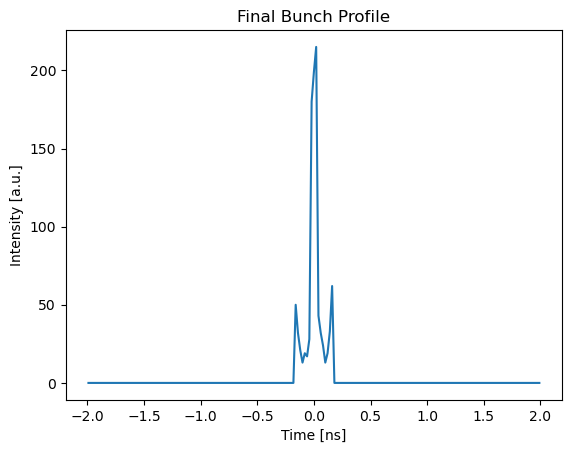

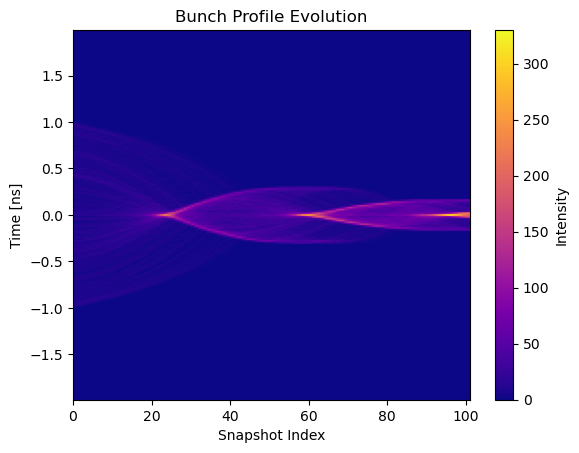

In [32]:
# Example RF schedule: ramp up second harmonic to split the bunch
rf_schedule = {
    "V2": lambda turn: 300 * (turn / 500) if turn < 500 else 300
}

res = track_longitudinal_with_profiles(
    N_particles=1000,
    turns=2000,
    rf=rf,
    mach=mach,
    damp_noise=damp_noise,
    sample_interval=20,
    rf_schedule=rf_schedule
)

# Plot final bunch profile
plt.plot(res["bin_centers"] * 1e9, res["profiles"][-1])
plt.xlabel("Time [ns]")
plt.ylabel("Intensity [a.u.]")
plt.title("Final Bunch Profile")
plt.show()

# 2D evolution (splitting/merging visualization)
plt.imshow(
    res["profiles"].T,
    aspect='auto',
    extent=[0, len(res["turns"]), res["bin_centers"][0]*1e9, res["bin_centers"][-1]*1e9],
    origin='lower',
    cmap='plasma'
)
plt.colorbar(label="Intensity")
plt.xlabel("Snapshot Index")
plt.ylabel("Time [ns]")
plt.title("Bunch Profile Evolution")
plt.show()


In [36]:
res["profiles"].shape

(101, 199)

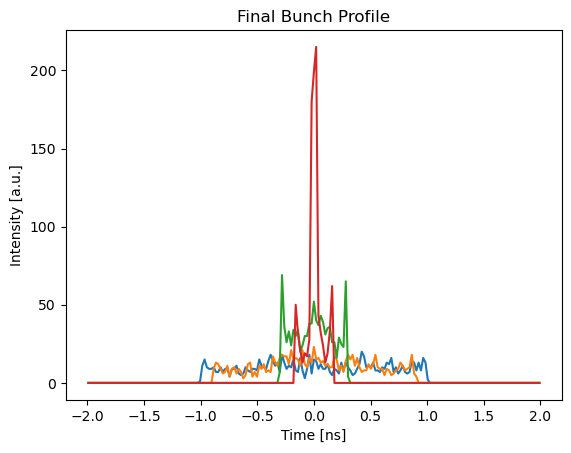

In [37]:
plt.plot(res["bin_centers"] * 1e9, res["profiles"][0])
plt.plot(res["bin_centers"] * 1e9, res["profiles"][10])
plt.plot(res["bin_centers"] * 1e9, res["profiles"][50])
plt.plot(res["bin_centers"] * 1e9, res["profiles"][100])
plt.xlabel("Time [ns]")
plt.ylabel("Intensity [a.u.]")
plt.title("Final Bunch Profile")
plt.show()

In [2]:
def cosine_square_pulse(
    t: np.ndarray,
    pulse_width: float,
    pw_type: str = 'fixed',
    amplitude: float = 1.0,
    phase_freq: float = None,
    phase_shift: float = 0.0,
    degrees: bool = False
) -> np.ndarray:
    """
    Generate a cosine-squared pulse with optional frequency-based phase shift.

    Args:
        t (np.ndarray): Time array.
        pulse_width (float): Pulse width in seconds.
        pw_type (str, optional): Pulse width type. 'fixed', 'fwhm', or 'rms'. Defaults to 'fixed'.
        amplitude (float, optional): Amplitude of the pulse. Defaults to 1.0.
        phase_freq (float, optional): Frequency in Hz for phase shift calculation. If None, uses internal cosine width.
        phase_shift (float, optional): Phase shift (in degrees if degrees=True, else in radians).
        degrees (bool, optional): Whether phase_shift is in degrees. Defaults to False.

    Returns:
        np.ndarray: Cosine-squared pulse.
    """
    # Convert width to full extent (99.99%)
    pw_type = pw_type.lower()
    if pw_type == 'fwhm':
        period = (pulse_width / (2 * np.sqrt(2 * np.log(2)))) * 7.0
    elif pw_type == 'rms':
        period = pulse_width * 7.0
    else:
        period = pulse_width

    # Handle phase shift
    phase = np.deg2rad(phase_shift) if degrees else phase_shift

    # Frequency-based phase shift (adjust waveform in time)
    if phase_freq is not None:
        # time shift = phase / (2πf)
        t_shift = -phase / (2 * np.pi * phase_freq)
    else:
        # fallback: use phase shift relative to pulse width period
        t_shift = -phase / (2 * np.pi) * period

    # Cosine-squared profile
    cos_arg = (2 * np.pi * (t - t_shift)) / period + np.pi
    waveform = (np.cos(cos_arg) - 1) ** 2
    waveform /= np.max(waveform)

    # Apply windowing to keep only inside ±0.5*period
    mask = np.abs(t - t_shift) <= (0.5 * period)
    waveform[~mask] = 0.0

    return amplitude * waveform


In [7]:
def skew_gaus_pulse(
    t: np.ndarray,
    skew: float = 1.0,
    sigma: float = 1.0,
    FWHM: float = None,
    rf: float = None,
    BW: float = 1,
    phase_shift: float = 0.0,
    phase_freq: float = None
) -> np.ndarray:
    """
    Generate a skewed Gaussian pulse with optional phase shift based on frequency.

    Args:
        t (np.ndarray): Time array.
        skew (float, optional): Skew factor. Defaults to 1.0.
        sigma (float, optional): Standard deviation. Defaults to 1.0.
        FWHM (float, optional): Full width at half maximum. Defaults to None.
        rf (float, optional): Radio frequency. Defaults to None.
        BW (float, optional): Bandwidth. Defaults to 1.
        phase_shift (float, optional): Phase shift in degrees. Defaults to 0.0.
        phase_freq (float, optional): Frequency in Hz for phase shift calculation. Defaults to None.

    Returns:
        np.ndarray: Skewed Gaussian pulse with optional phase shift.
    """
    t_shift = (phase_shift / 360.0) / phase_freq if phase_freq else 0.0
    t = t - t_shift
    gaus = gaussian_pulse(t, sigma, FWHM, rf, BW, phase_shift, phase_freq)
    print(gaus)
    # Calculate the skew factor using the error function
    skew_factor = 1 - erf(-1 * (skew * t / (np.sqrt(2) * sigma)))
    print(skew_factor)
    # Apply the skew factor to the Gaussian pulse
    skewed_pulse = gaus * skew_factor
    # Normalize the skewed pulse to have a maximum amplitude of 1
    return skewed_pulse / np.max(skewed_pulse)


In [11]:
# --- Test gaussian_pulse
t = np.linspace(-0.5/HSR_RF_24M,0.5/HSR_RF_24M, 3000)  # time array for 1 RF cycle
sig1 = skew_gaus_pulse(t, 2.0, sigma=HSR_PP_BUNCH_LENGTH_23GeV, phase_shift=0.0, phase_freq=HSR_RF_24M)
sig2 = skew_gaus_pulse(t, 2.0,FWHM=HSR_PP_BUNCH_LENGTH_23GeV*2*np.sqrt(2*np.log(2)), phase_shift=0.0, phase_freq=HSR_RF_24M )    
sig3 = skew_gaus_pulse(t, 2.0, rf=HSR_RF_24M, BW=7, phase_shift=0.0, phase_freq=HSR_RF_24M) 
sig4 = skew_gaus_pulse(t, 2.0, sigma=HSR_PP_BUNCH_LENGTH_23GeV, phase_shift=-45.0, phase_freq=HSR_RF_24M)    
sig5 = skew_gaus_pulse(t, 2.0, sigma=HSR_PP_BUNCH_LENGTH_23GeV, phase_shift=45.0, phase_freq=HSR_RF_24M)    

plt.figure(figsize=(10, 6))
plt.plot(t, sig1, label='sig1')
plt.plot(t, sig2, label='sig2')
plt.plot(t, sig3, label='sig3')
plt.plot(t, sig4, label='sig4')
plt.plot(t, sig5, label='sig5')

plt.legend()
plt.show()

(array([6.79218823e-33, 7.49722193e-33, 8.27489340e-33, ...,
       8.27489340e-33, 7.49722193e-33, 6.79218823e-33]), 1.6678204759907602e-09)
[0. 0. 0. ... 2. 2. 2.]


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogeneous part.